# Анализ оттока клиентов банка "Метанпромбанк"

**Описание проблемы:** в последнее время в банке значительно повысился отток клиентов, который угрожает существованию банка.

**Заказчик:** отдел маркетинга - информация нужна менеджеру, который занимается маркетинговыми кампаниями и работает в тесной связи с менеджерами продуктов.

**Необходимо получить:** эффективно выделенные сегменты отточных клиентов, чтобы они были однородными, высокооточными и покрывали максимум проблемных зон банка.

**Цель исследования:** проанализировать клиентов регионального банка и выделить сегменты клиентов, которые склонны уходить из банка.

**Описание данных:** датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск. Путь к файлу: "https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F" .
- `user_id` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `сity` — город,
- `gender` — пол,
- `age` — возраст,
- `equity`  — количество баллов собственности
- `balance` — баланс на счёте,
- `products` — количество продуктов, которыми пользуется клиент,
- `credit_card` — есть ли кредитная карта,
- `last_activity` — активный клиент,
- `est_salary` — заработная плата клиента,
- `churn` — ушёл или нет.


**Исследование пройдет в 6 этапов:**

1) Загрузка и обзор данных: 

   - проверка корректности наименования колонок;
   - исследование дубликатов;
   - добавление дополнительных столбцов с закодированными колонками gender и city (метод pandas.get_dummies);
   - исследование и определение типа пропусков (MCAR, MAR, MNAR);
   - проверка соответствия типов данных;
   - проверка на наличие аномалий.

2) Исследовательский анализ
  
   - сравнение количественных портретов клиентов в разрезе оттока по всем показателям;
   - распределение непрерывных (в разрезе оттока);
   - анализ уровня оттока по категориям;
   - корреляционный анализ.
   
3) Проверка статистических гипотез  

4) Подведение промежуточного итога: определение предварительного списка показателей, которые стратегически влияют на отток, их значения и интервалы.

5) Сегментация на основе стратегических показателей: выделение основных признаков, которые повышают отток, при этом уменьшая сегментацию; приоритезация сегментов.

6) Формирование выводов и рекомендаций для заказчика, составление презентации.


**ССЫЛКА НА ПРЕЗЕНТАЦИЮ:** https://disk.yandex.ru/i/AHa2b_92zXwtGw

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots

from scipy import stats as st
from statsmodels.stats.weightstats import ztest as ztest
import math as mth
import phik

import warnings
warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None


## Загрузка и обзор данных

In [2]:
# чтение файла bank_scrooge.csv с данными и сохранение его в переменную 
path = "https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F" 
data = pd.read_csv(path)

data.head()

USERID  score       city gender   age  equity     balance  products  \
0  183012  850.0    Рыбинск      Ж  25.0       1    59214.82         2   
1  146556  861.0    Рыбинск      Ж  37.0       5   850594.33         3   
2  120722  892.0    Рыбинск      Ж  30.0       0         NaN         1   
3  225363  866.0  Ярославль      Ж  51.0       5  1524746.26         2   
4  157978  730.0  Ярославль      М  34.0       5      174.00         1   

   credit_card  last_activity  EST_SALARY  churn  
0            0              1    75719.14      1  
1            1              0    86621.77      0  
2            1              1   107683.34      0  
3            0              1   174423.53      1  
4            1              0    67353.16      1

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


**Вывод:** в данных 10000 записей, есть пропуски в колонках age и balance, необходимо будет переименовать колонки USERID И EST_SALARY для комфортной работы, колонку age привести к типу int.

### Переименование колонок

In [4]:
# приводим колонки к нижнему регистру
data.columns = data.columns.str.lower()

# переименовывыем userid
data.rename(columns={'userid' : 'user_id'}, inplace=True)

data.head()

user_id  score       city gender   age  equity     balance  products  \
0   183012  850.0    Рыбинск      Ж  25.0       1    59214.82         2   
1   146556  861.0    Рыбинск      Ж  37.0       5   850594.33         3   
2   120722  892.0    Рыбинск      Ж  30.0       0         NaN         1   
3   225363  866.0  Ярославль      Ж  51.0       5  1524746.26         2   
4   157978  730.0  Ярославль      М  34.0       5      174.00         1   

   credit_card  last_activity  est_salary  churn  
0            0              1    75719.14      1  
1            1              0    86621.77      0  
2            1              1   107683.34      0  
3            0              1   174423.53      1  
4            1              0    67353.16      1

### Исследование дубликатов

Проверим явные дубликаты по всему датасету

In [5]:
data.duplicated().sum()

0

Дубликатов нет. Проверим дубликаты в столбце user_id, т.к. это единственное поле с уникальными значениями.

In [6]:
data['user_id'].duplicated().sum()

73

Найдено 73 записей с одинаковыми значениями. Повторно проверим дубликаты по user_id, но на этот так вместе с полом.

In [7]:
data[['user_id','gender']].duplicated().sum()

41

Здесь нашлось 41-о совпадение. Появилось предположение о том, что один и тот же пользователь является клиентом банка в двух разных городах. Проверим дубликаты по user_id вместе с городом.

In [8]:
data[['user_id', 'city']].duplicated().sum()

0

Дубликаты отсутсвуют. Добавим к проверке пол.

In [9]:
data[['user_id','gender','city']].duplicated().sum()

0

Дубликаты по трем столбцам **user_id**, **gender**, **city** - отсутствуют. Скорее всего, у каждого из городов своя база данных, соответственно id пользователей при объединении данных могут совпадать (union all), совпадение пола в данном случае можно считать случайным.

### Кодирование колонок gender и city

Для дальнейшего исследования необходимо категориальные данные привести к количественным, чтобы была возможность строить графики и исследовать результаты корреляции.

In [10]:
# сохраняем значения столбца gender
data['gender_1'] = data['gender'].copy()

# сохраняем значения столбца city
data['city_1'] = data['city'].copy()

data.head()

user_id  score       city gender   age  equity     balance  products  \
0   183012  850.0    Рыбинск      Ж  25.0       1    59214.82         2   
1   146556  861.0    Рыбинск      Ж  37.0       5   850594.33         3   
2   120722  892.0    Рыбинск      Ж  30.0       0         NaN         1   
3   225363  866.0  Ярославль      Ж  51.0       5  1524746.26         2   
4   157978  730.0  Ярославль      М  34.0       5      174.00         1   

   credit_card  last_activity  est_salary  churn gender_1     city_1  
0            0              1    75719.14      1        Ж    Рыбинск  
1            1              0    86621.77      0        Ж    Рыбинск  
2            1              1   107683.34      0        Ж    Рыбинск  
3            0              1   174423.53      1        Ж  Ярославль  
4            1              0    67353.16      1        М  Ярославль

In [11]:
# кодируем gender
data = pd.get_dummies(data, columns=['gender'])

# кодируем city
data = pd.get_dummies(data, columns=['city'])

In [12]:
# переименовываем колонки
data.rename(columns={'gender_1':'gender',
                     'gender_М':'is_male',
                     'gender_Ж': 'is_female',
                     'city_1':'city',
                     'city_Ростов': 'is_Rostov',
                     'city_Рыбинск': 'is_Rybinsk',
                     'city_Ярославль':'is_Yaroslavl'}, inplace=True)

data.head()

user_id  score   age  equity     balance  products  credit_card  \
0   183012  850.0  25.0       1    59214.82         2            0   
1   146556  861.0  37.0       5   850594.33         3            1   
2   120722  892.0  30.0       0         NaN         1            1   
3   225363  866.0  51.0       5  1524746.26         2            0   
4   157978  730.0  34.0       5      174.00         1            1   

   last_activity  est_salary  churn gender       city  is_female  is_male  \
0              1    75719.14      1      Ж    Рыбинск          1        0   
1              0    86621.77      0      Ж    Рыбинск          1        0   
2              1   107683.34      0      Ж    Рыбинск          1        0   
3              1   174423.53      1      Ж  Ярославль          1        0   
4              0    67353.16      1      М  Ярославль          0        1   

   is_Rostov  is_Rybinsk  is_Yaroslavl  
0          0           1             0  
1          0           1             0  
2          0           1             0  
3          0           0             1  
4          0           0             1

### Исследование пропусков

#### Рассмотрим пропуски в колонке **age**.

In [13]:
data['age'].isna().sum()

26

Здесь у нас всего 26 пропусков - 0.26%. Посмотрим как они распределились в зависимости от пола и города.

In [14]:
nulls = data.query('age.isna() == True').groupby(['city', 'gender']).agg({'user_id':'count'})\
                                        .rename(columns={'user_id':'nulls'})
nulls

nulls
city      gender       
Ростов    Ж           1
Рыбинск   Ж           8
          М           4
Ярославль Ж           3
          М          10

Видимо мужчины из Ярославля не очень любят делиться информацией о своем возрасте :)

В целом, пропуски в столбце age можно отнести к случайным и заполнить их медианным значением в зависимости от пола и города проживания.

In [15]:
# female median age in Rostov 
rostov_age = data.query('is_Rostov == 1 & is_male == 0')['age'].median()

# female median age in Rybinsk
rybinsk_female = data.query('is_Rybinsk == 1 & is_male == 0')['age'].median()

# male median age in Rybinsk
rybinsk_male = data.query('is_Rybinsk == 1 & is_male == 1')['age'].median()

# female median age in Yaroslavl
yaroslavl_female = data.query('is_Yaroslavl == 1 & is_male == 0')['age'].median()

# male median age in Yaroslavl
yaroslavl_male = data.query('is_Yaroslavl == 1 & is_male == 1')['age'].median()


In [16]:
data.loc[((data['is_Rostov'] == 1) & (data['age'].isna() == True)), 'age'] = rostov_age

data.loc[((data['is_Rybinsk'] == 1) & (data['age'].isna() == True) & (data['is_male'] == 0)), 'age'] = rybinsk_female
data.loc[((data['is_Rybinsk'] == 1) & (data['age'].isna() == True) & (data['is_male'] == 1)), 'age'] = rybinsk_male

data.loc[((data['is_Yaroslavl'] == 1) & (data['age'].isna() == True) & (data['is_male'] == 0)), 'age'] = yaroslavl_female
data.loc[((data['is_Yaroslavl'] == 1) & (data['age'].isna() == True) & (data['is_male'] == 1)), 'age'] = yaroslavl_male

In [17]:
# проверка
data['age'].isna().sum()

0

#### Рассмотрим пропуски в колонке **balance**.

In [18]:
balance_nulls = data['balance'].isna().sum()

print(f'Всего пропусков - {balance_nulls}, что составляет {balance_nulls/10000 * 100}% всех данных.')

Всего пропусков - 2295, что составляет 22.95% всех данных.


Почти 23% пропусков, достаточно высокий процент. Необходимо определить тип пропусков и найти вариант их обработки. 

Т.к. у нас главным критерием основной задачи исследования являтся *отточность*, с нее и начнем. Рассмотрим доли пропусков при разбиении по параметру *churn*.

In [19]:
# датасет с пропусками balance
balance_nulls = data.query('balance.isna() == True')

balance_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2295 entries, 2 to 9997
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        2295 non-null   int64  
 1   score          2295 non-null   float64
 2   age            2295 non-null   float64
 3   equity         2295 non-null   int64  
 4   balance        0 non-null      float64
 5   products       2295 non-null   int64  
 6   credit_card    2295 non-null   int64  
 7   last_activity  2295 non-null   int64  
 8   est_salary     2295 non-null   float64
 9   churn          2295 non-null   int64  
 10  gender         2295 non-null   object 
 11  city           2295 non-null   object 
 12  is_female      2295 non-null   uint8  
 13  is_male        2295 non-null   uint8  
 14  is_Rostov      2295 non-null   uint8  
 15  is_Rybinsk     2295 non-null   uint8  
 16  is_Yaroslavl   2295 non-null   uint8  
dtypes: float64(4), int64(6), object(2), uint8(5)
memory 

In [20]:
balance_nulls.loc[balance_nulls['churn'] == 1, 'churn_str'] = 'отточный'
balance_nulls.loc[balance_nulls['churn'] == 0, 'churn_str'] = 'не отточный'

In [21]:
churn_grouped = balance_nulls.groupby('churn_str', as_index=False).agg({'user_id':'count'}).rename(columns={'user_id':'nulls'})
churn_grouped

churn_str  nulls
0  не отточный   2282
1     отточный     13

In [22]:
fig = go.Figure(data=[go.Pie(labels = churn_grouped['churn_str'], values=churn_grouped['nulls'])])

fig.update_layout(title='Доли пропусков по параметру отточности',
                 legend_title_text='Отточность')

fig.show()

По параметру отточности 99.4% пропусков наблюдается у пользователей, которые являются *не отточными*.

Весь анализ будет построен на данных с пропусками по балансу. На столбчатых диаграммах по полям *products* и *equity* будут отображены общее количество и доли пропусков, на гистограмме для полей *est_salary* и *score* распределение пропусков с разбивкой по бинарным параметрам *last_activity* и *credit_card* для обоих видов графиков. В итоге у нас по каждому параметру будет построено 6 диаграмм.

Для этого создадим две функции **get_grouped** - для формирования сводных таблиц по нужным показателям и **get_parameter_plots** - для формирования графиков. 

In [23]:
def get_grouped(parameter_1, parameter_2):
    
    '''
    функция для формирования сводной таблицы по главному и второстепенному параметрам,
    в которой будут отражены общее количество и доли пропусков.
    '''
    
    full_nulls = balance_nulls.groupby(parameter_1, as_index=False).agg({'user_id':'count'})\
                        .rename(columns={'user_id':'full_nulls'})

    grouped = balance_nulls.groupby([parameter_1, parameter_2], as_index=False).agg({'user_id':'count'})\
                                .rename(columns={'user_id':'nulls'})\
                                .sort_values(by='nulls', ascending=False)

    grouped = grouped.merge(full_nulls, on=parameter_1, how='left')
    grouped['percentage'] = grouped['nulls']/grouped['full_nulls']


    return grouped

In [24]:
def get_parameter_plots(data_p, data_e, parameter_p, parameter_e, hue, subtitle, legend):
    
    '''
    функция для построения графиков, отображающие:
    общее кол-во и доли пропусков по кол-ву продуктов и кол-ву эл. собственности,
    а также распределения зарплат и баллов кредитного скоринга с разбивкой по
    указанному параметру hue
    
    '''
    
    plt.figure(figsize=(20, 18))

    plt.suptitle(f'Анализ пропусков в разрезе {subtitle}', fontweight='bold', fontsize=15)
    sns.set_style('whitegrid')

    ax1 = plt.subplot(3, 2, 1)
    sns.barplot(x=parameter_p, y='percentage', data=data_p, hue=hue, palette='rocket', ax=ax1)
    plt.title('Доля пропусков по продуктам')
    plt.xlabel('Количество продуктов')
    plt.ylabel('Доля пропусков')
    plt.legend(title=legend)

    ax2 = plt.subplot(3, 2, 2)
    sns.barplot(x=parameter_p, y='nulls', data=data_p, hue=hue, palette='rocket', ax=ax2)
    plt.title('Количество пропусков по продуктам')
    plt.xlabel('Количество продуктов')
    plt.ylabel('Количество пропусков')
    plt.legend(title=legend)
    
    ax3 = plt.subplot(3, 2, 3)
    sns.barplot(x=parameter_e, y='percentage', data=data_e, hue=hue, palette='rocket', ax=ax3)
    plt.title('Доля пропусков по кол-ву эл. собственности')
    plt.xlabel('Количество эл. собственности')
    plt.ylabel('Доля пропусков')
    plt.legend(title=legend)
    
    ax4 = plt.subplot(3, 2, 4)
    sns.barplot(x=parameter_e, y='nulls', data=data_e, hue=hue, palette='rocket', ax=ax4)
    plt.title('Количество пропусков по кол-ву эл. собственности')
    plt.xlabel('Количество собственности')
    plt.ylabel('Количество пропусков')
    plt.legend(title=legend)

    ax5 = plt.subplot(3, 2, 5)
    sns.histplot(x='score', data=balance_nulls, kde=True, hue=hue, palette='mako', ax=ax5)
    plt.title('Распределение пропусков по кредитному скорингу')
    plt.xlabel('Кредитный скоринг')
    plt.ylabel('Количество')


    ax6 = plt.subplot(3, 2, 6)
    sns.histplot(x='est_salary', data=balance_nulls, kde=True, hue=hue, palette='mako', ax=ax6)
    plt.title('Распределение пропусков по зарплате')
    plt.xlabel('Зарплата')
    plt.ylabel('Количество')


    plt.show()

Рассмотрим пропуски в разрезе последней **активности пользователя - last_activity**.

In [25]:
# products
p_grouped = get_grouped('products', 'last_activity')

display(p_grouped)

#equity
e_grouped = get_grouped('equity', 'last_activity')
e_grouped

products  last_activity  nulls  full_nulls  percentage
0         1              1   1083        1950    0.555385
1         1              0    867        1950    0.444615
2         2              1    170         315    0.539683
3         2              0    145         315    0.460317
4         3              0     21          29    0.724138
5         3              1      8          29    0.275862
6         0              0      1           1    1.000000

equity  last_activity  nulls  full_nulls  percentage
0       0              1   1199        2180     0.55000
1       0              0    981        2180     0.45000
2       1              1     62         114     0.54386
3       1              0     52         114     0.45614
4       3              0      1           1     1.00000

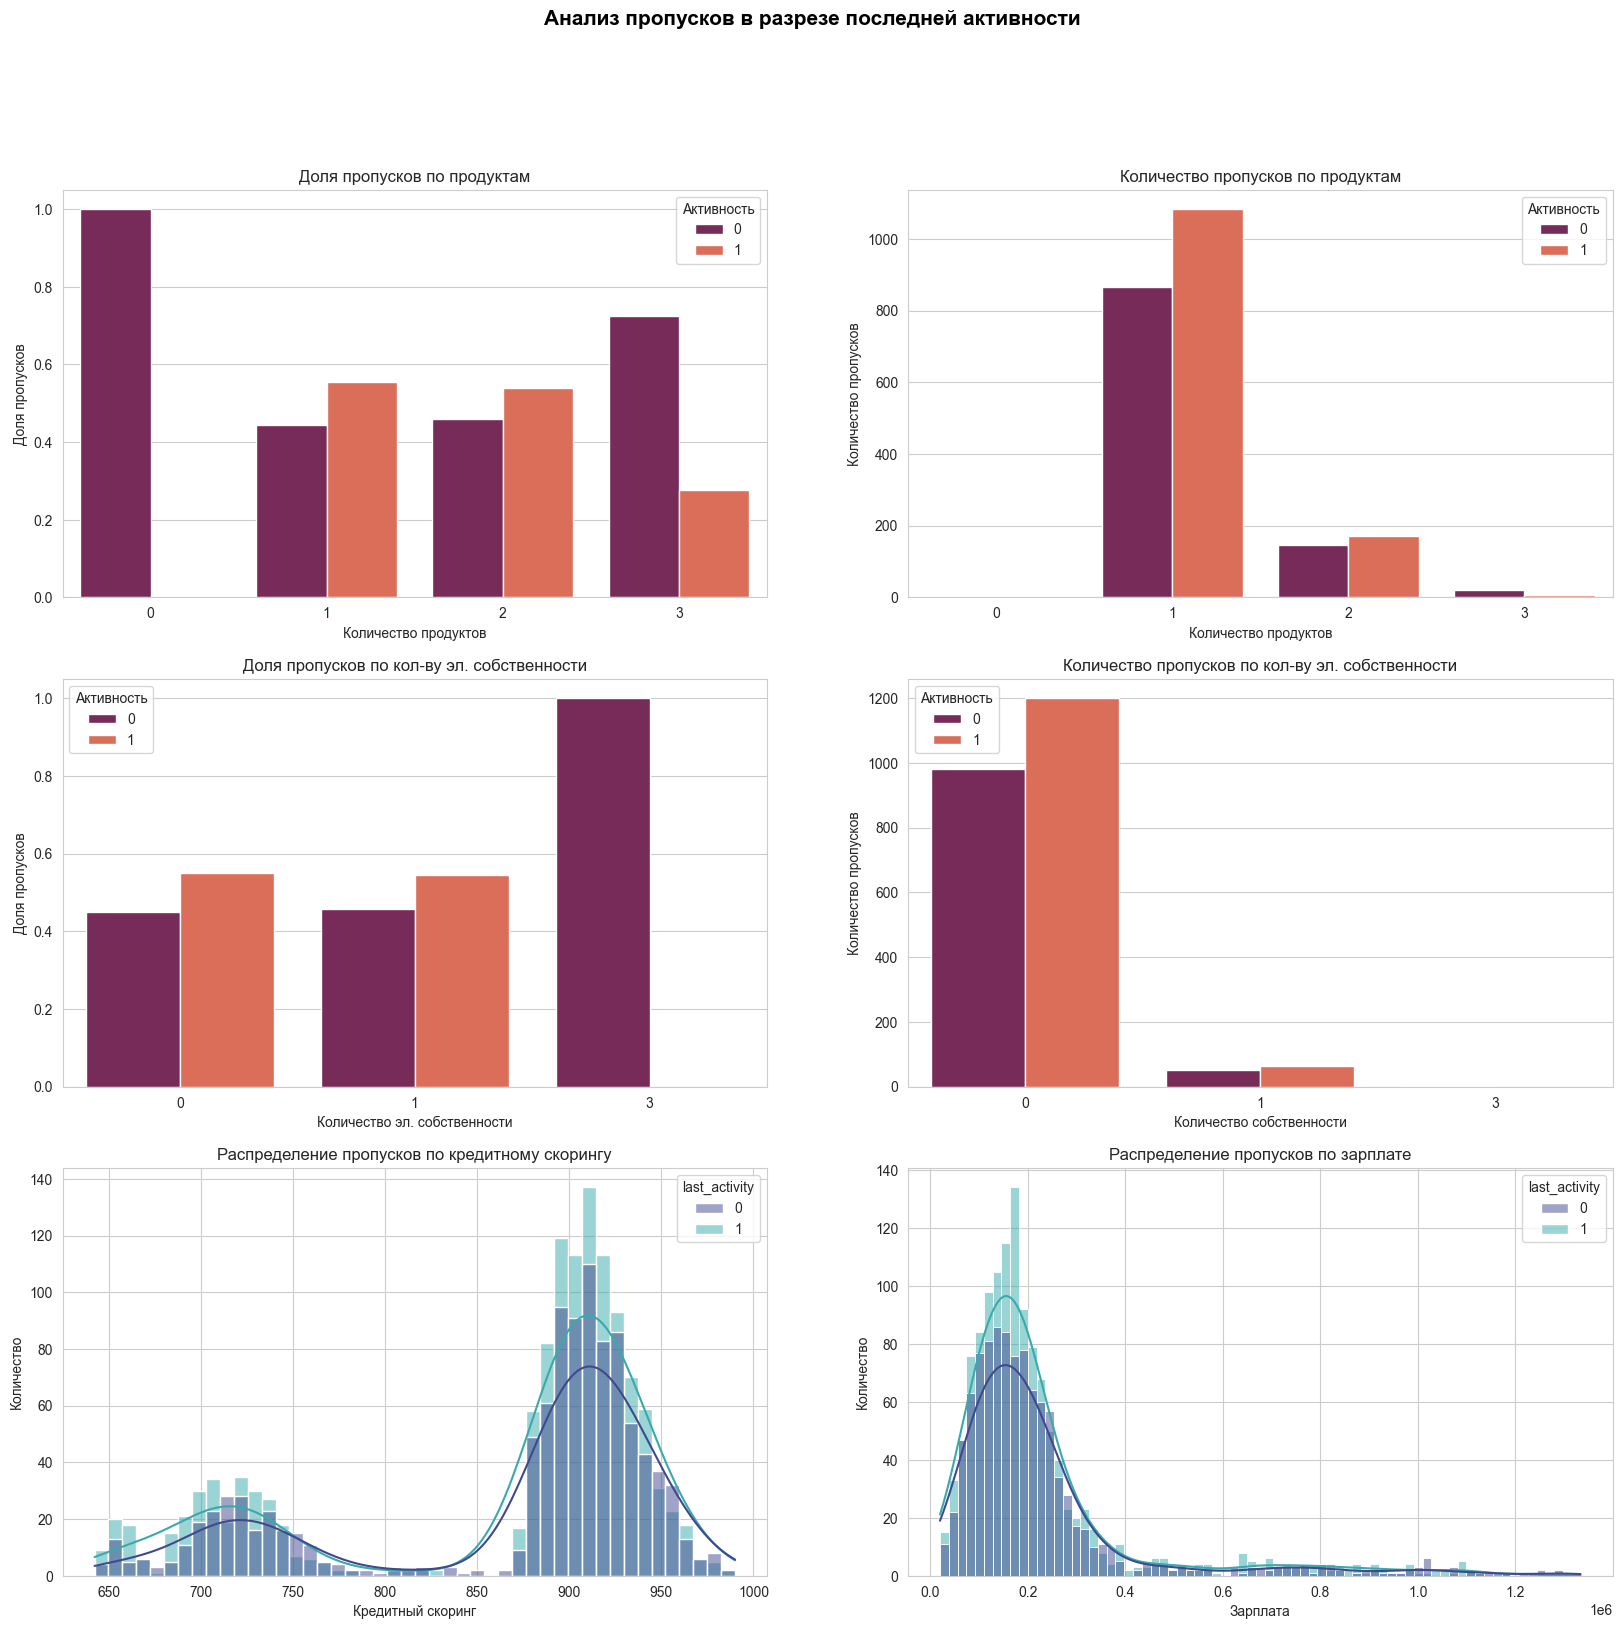

In [26]:
subtitle = 'последней активности'
legend = 'Активность'
get_parameter_plots(p_grouped, e_grouped, 'products', 'equity','last_activity', subtitle, legend)

Наблюдения:

- **Количество продуктов:** чаще остальных баланс не заполнен у пользователей, которые пользуются только *одним продуктом* (почти 2000 пропусков), при этом - это **активные** пользователи (более 1000). Если посмотреть на доли пропусков, то пользователи с *одним и двумя продуктами* также чаще являются *активными*, но при этом соотношение долей примерно 55 к 45 (т.е. почти одинаковое). *Меньше всего пропусков* встречается среди пользователей, у которых *0 или 3 продукта*, при этом преимущественно они являются **не активными**.
- **Количество элементов собственности:** более 2000 пропусков среди пользователей, которые **не имееют собственности**, преимущественно - **активные**, но соотношение долей активный/не активный примерно 55% и 45%. Хоть среди пользователей с *одним объектом собственности* пропуски встречаются редко, однако они также преимущественно **активные** (такое же соотношение доле 55% и 45%). Есть всего один пользователь с *тремя элементами собственности* и незаполненным балансом, и он - **не активный**.
- **Кредитный скоринг**: можно сказать, гистограмма разделилась на две маленькие. Чаще остальных незаполненный баланс встречается у пользователей со скорингом от 650 до 800 и от 850 до 1000 соответственно, и преобладают в этих диапазонах **активные** пользователи, однако не сильно.
- **Зарплата**: гистограмма имеет колокообразную форму с пиком в районе 200к с ярковыраженным длинным хвостом вправо, преимущество **активных** пользователей.


Если смотреть на количество пропусков в разрезе последней активности, то преимущество у активных пользователей, однако если посмотреть на доли, то тут почти равное процентное соотношение наблюдается как по кол-ву продуктов, так и по кол-ву эл. собственности - примерно 55% активных и 45% не активных. Один пропуск у пользователя с нулевым кол-вом продуктов и один пропуск у пользователя с тремя эл. собственности. То есть здесь провести зависимость количества пропусков от роста кол-ва продуктов или эл. собсвенности нельзя. Есть статистика, которая говорит что **больше всего пропусков у пользователей с одним продуктом и нулевым кол-ом элементов собственности, при этом активность у них почти одинаковая**.

Рассмотрим пропуски в разрезе **наличия кредитной карты - credit_card**.

In [27]:
# products
p_grouped = get_grouped('products', 'credit_card')

display(p_grouped)

#equity
e_grouped = get_grouped('equity', 'credit_card')
e_grouped

products  credit_card  nulls  full_nulls  percentage
0         1            1   1599        1950    0.820000
1         1            0    351        1950    0.180000
2         2            1    257         315    0.815873
3         2            0     58         315    0.184127
4         3            1     16          29    0.551724
5         3            0     13          29    0.448276
6         0            0      1           1    1.000000

equity  credit_card  nulls  full_nulls  percentage
0       0            1   1775        2180    0.814220
1       0            0    405        2180    0.185780
2       1            1     97         114    0.850877
3       1            0     17         114    0.149123
4       3            0      1           1    1.000000

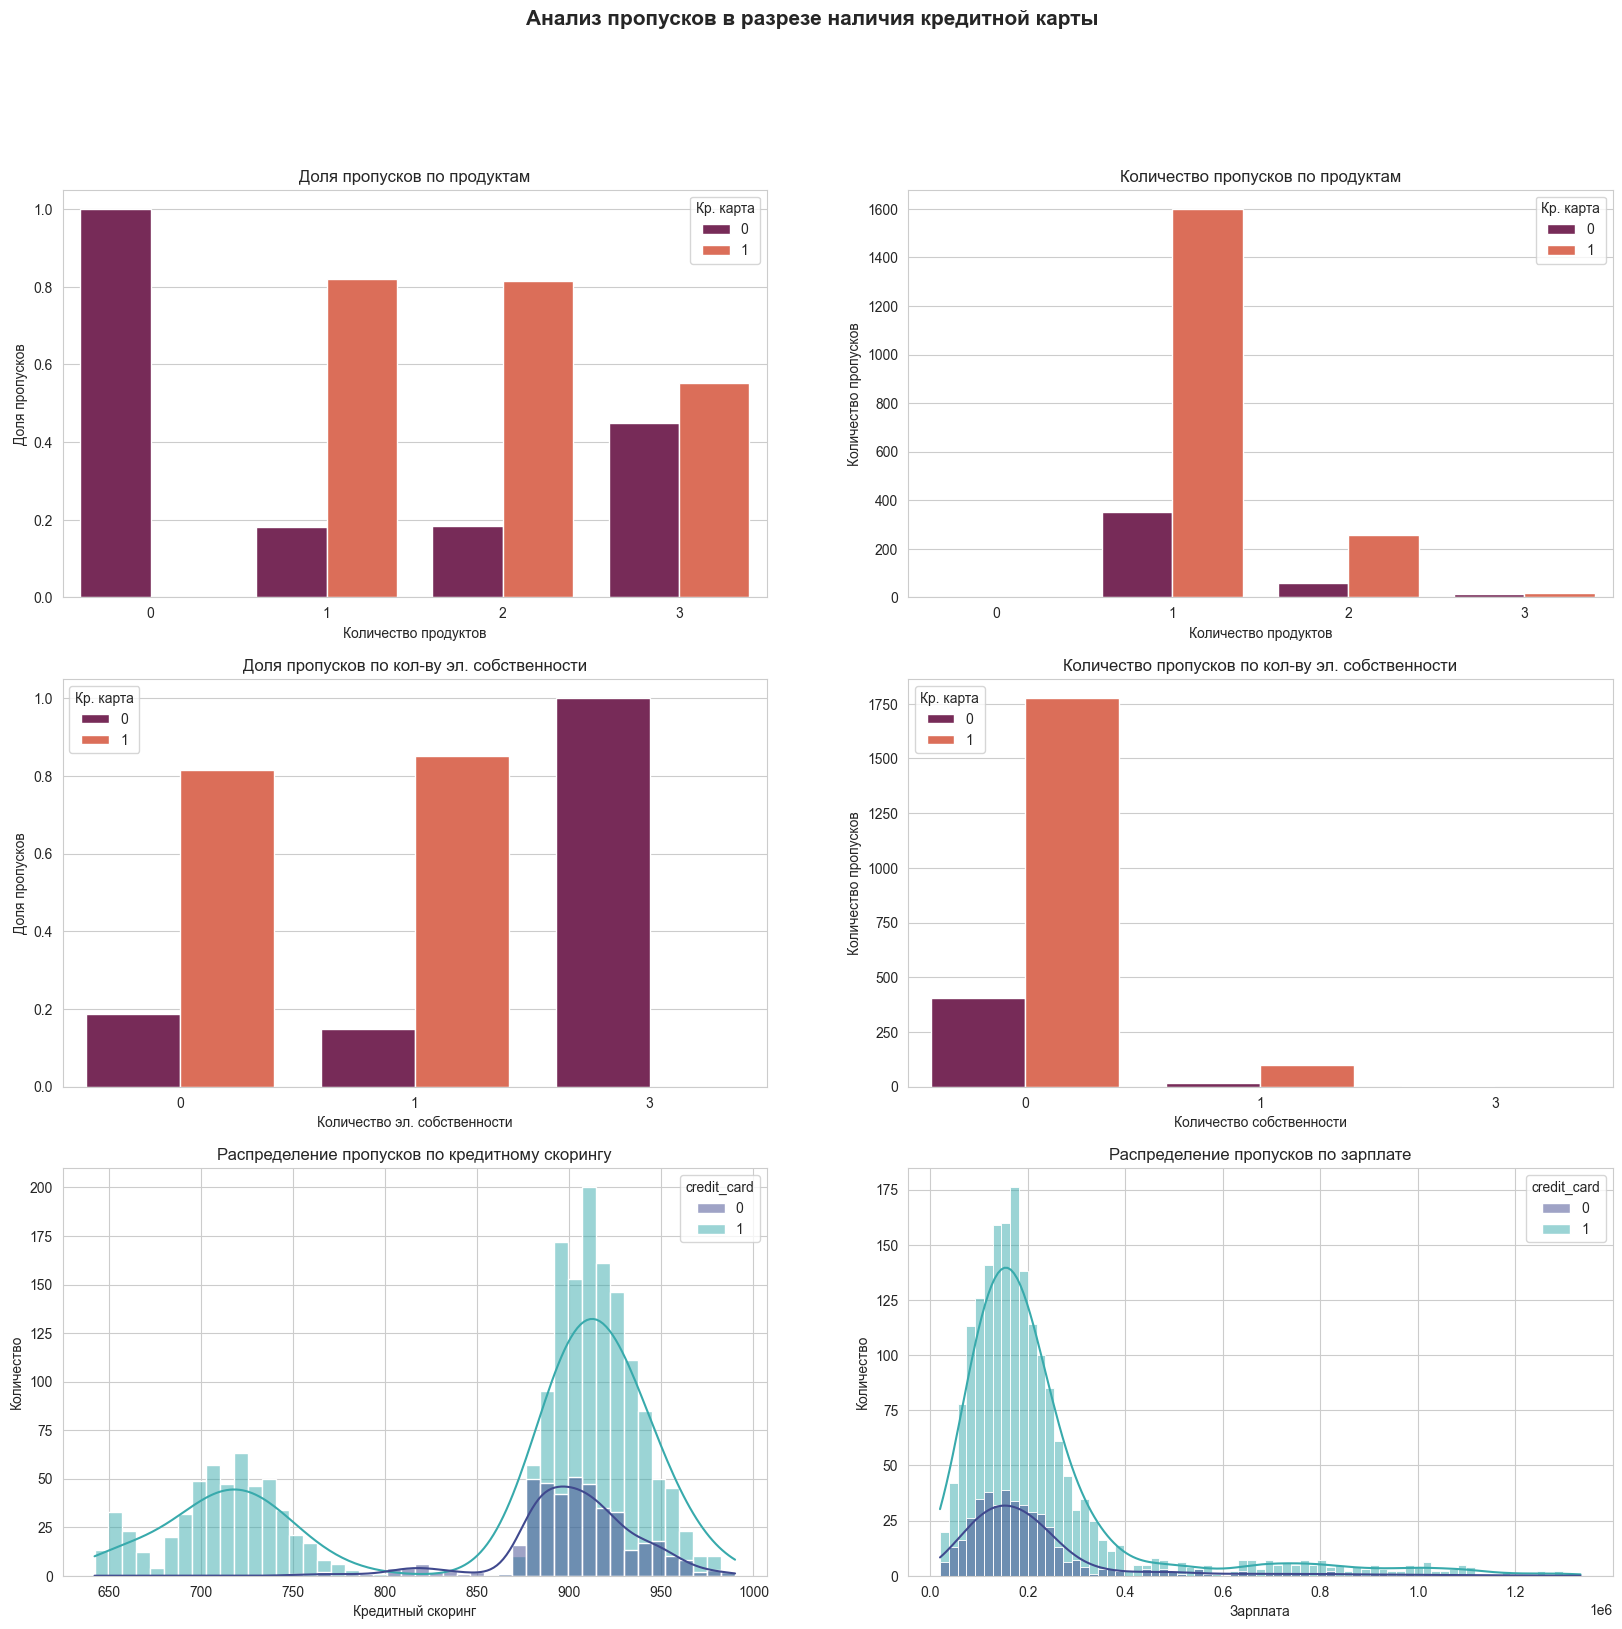

In [28]:
subtitle = 'наличия кредитной карты'
legend = 'Кр. карта'
get_parameter_plots(p_grouped, e_grouped, 'products', 'equity','credit_card', subtitle, legend)

Наблюдения:

- **Количество продуктов:** почти у 2 тыс. пользователей с *одним продуктом* **не заполнен баланс** и у чуть более 300 - с двумя продуктами, при этом - это пользователи преимущественно с **кредитной картой**. Однако **доли пропусков по кредитной карте** в отличии от активности имеют бОльшее различие - примерно **у 82% пользователей с одним и двумя продуктами и кредитной картой не заполнен баланс**, несмотря на то, что пользователей с тремя продуктами мало - среди них также *преобладает признак наличия кредитной карты*. Есть только один пользователь с нулевым кол-вом продуктов и соотвественно у него нет кредитной карты.
- **Количество элементов собственности:** больше *2 тыс. пользователей* с незаполненным балансом *не имеют объектов собственности*, чуть *более 100 имеют один объект*, и всего один человек с незаполненным балансом имеет 3 эл. собственности и не имеет кредитной карты. У пользователей с нулевым и единичным показателями эл. собственности пропуски преобладают среди тех, кто **пользуется кредитной картой**. Но здесь также, как и по количеству продуктов, **доли пропусков в разрезе наличия кредитной карты преобладают - более 80%**.
- **Кредитный скоринг:** на гистограмме видны два ярко выраженных "колокола". Первый имеет диапазон *от 650 до 800 баллов*, и эти пользователи пользуются **исключительно кредитной картой**. Второй "колокол" находится в диапазоне *от 850 до 1000 баллов*, здесь пользователи *без кредитной карты* уже есть, но всё же явное преимущество за теми, кто пользуется кредитками.
- **Зарплата:** можно сказать, что *гистограмма* является почти полностью **"кредитной"**, пик в разре наличия/отсутвия крединой карты приходится примерно на 200к, однако разница в количестве огромная - *более 100*.

В отличии от параметра активности, здесь видна **ярко выраженная зависимость наличия кредитной карты и количества пропусков по проанализированным показателями - кол-во продуктов, кол-во эл. собственности, баллов кредитного скоринга и зарплаты**. По графикам мы видим, что основная часть пропусков находится среди пользователей, которые пользуются одним продуктом и вообще не имеют объектов собственности и среди них **преобладают пользователи с кредитной картой**. Тоже самое видно на гистограммах, особенно среди пользоваталей со скорингом пониже, среди них исключительно те, которые **пользуются кредитной картой**.

**Вывод**

Соответственно можно сделать вывод, что **пропуски не случайны** - это преимущественно пользователи, которые не собираются прекращать пользоваться услугами банка (не отточные) и пользуются кредитными картами. Есть прелположение, что NAN пропуски в данном случае это отрицательный баланс, но т.к. у нас нет возможности проследить разницу доходов-расходов из-за отсутствия информации, это остается лишь предположением.

Цель исследования изучить отточных клиентов, соответственно пропуски оставим. Просто будем иметь в виду, что среди не отточных есть категория предположительно "должников". 

### Работа с типами данных

Преобразуем тип float колонки age в int.

In [29]:
data['age'] = data['age'].astype('int')

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  float64
 2   age            10000 non-null  int32  
 3   equity         10000 non-null  int64  
 4   balance        7705 non-null   float64
 5   products       10000 non-null  int64  
 6   credit_card    10000 non-null  int64  
 7   last_activity  10000 non-null  int64  
 8   est_salary     10000 non-null  float64
 9   churn          10000 non-null  int64  
 10  gender         10000 non-null  object 
 11  city           10000 non-null  object 
 12  is_female      10000 non-null  uint8  
 13  is_male        10000 non-null  uint8  
 14  is_Rostov      10000 non-null  uint8  
 15  is_Rybinsk     10000 non-null  uint8  
 16  is_Yaroslavl   10000 non-null  uint8  
dtypes: float64(3), int32(1), int64(6), object(2), uint8

### Исследование аномалий

In [31]:
def get_characteristic(parameter, title):
    
    display(data[parameter].describe())
    print()
    
    plt.figure(figsize=(15, 5))
    sns.histplot(x=parameter, data=data, palette='mako')
    plt.title(title)
    plt.xlabel('')
    if parameter == 'balance_1':
        plt.xlim(0,10)
    if parameter == 'est_salary_1':
        plt.xlim(0,1000)
    plt.ylabel('Количество')

**Количество объектов собственности**

count    10000.000000
mean         2.627600
std          1.980836
min          0.000000
25%          0.000000
50%          3.000000
75%          4.000000
max          9.000000
Name: equity, dtype: float64

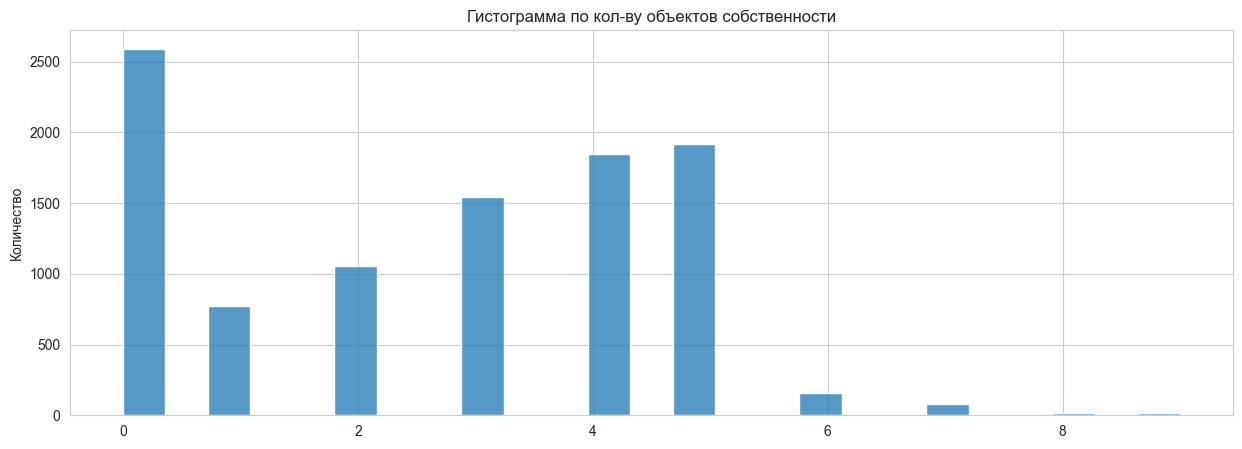

In [32]:
title = 'Гистограмма по кол-ву объектов собственности'
get_characteristic('equity', title)

In [33]:
data.query('equity >= 8')['user_id'].count()

30

**Количество продуктов**

count    10000.000000
mean         1.870100
std          0.792647
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          5.000000
Name: products, dtype: float64

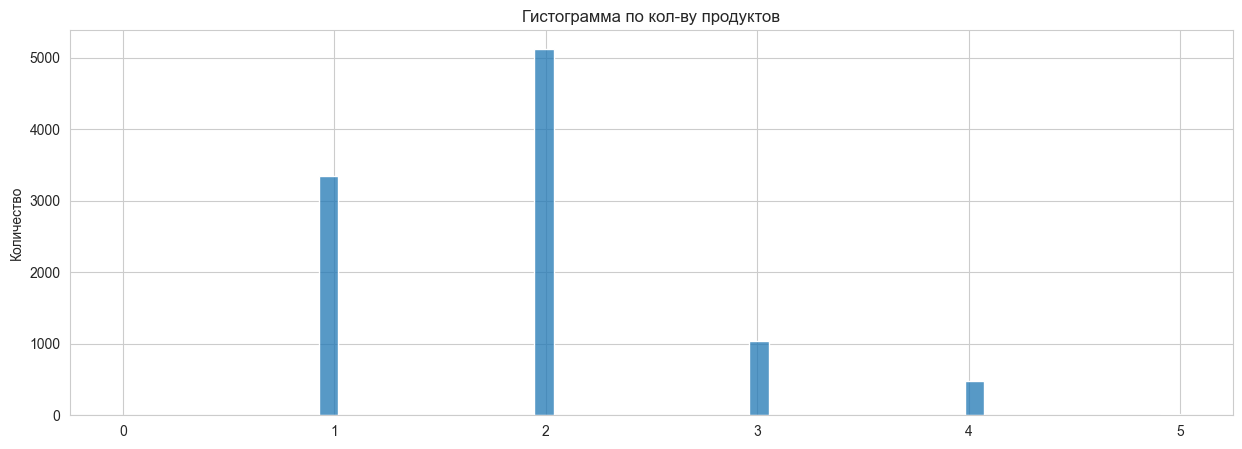

In [34]:
title = 'Гистограмма по кол-ву продуктов'
get_characteristic('products', title)

In [35]:
data.query('products == 0')['user_id'].count()

1

In [36]:
data.query('products == 5')['user_id'].count()

19

**Баллы кредитного скоринга**

count    10000.000000
mean       848.699400
std         65.448519
min        642.000000
25%        802.000000
50%        853.000000
75%        900.000000
max       1000.000000
Name: score, dtype: float64

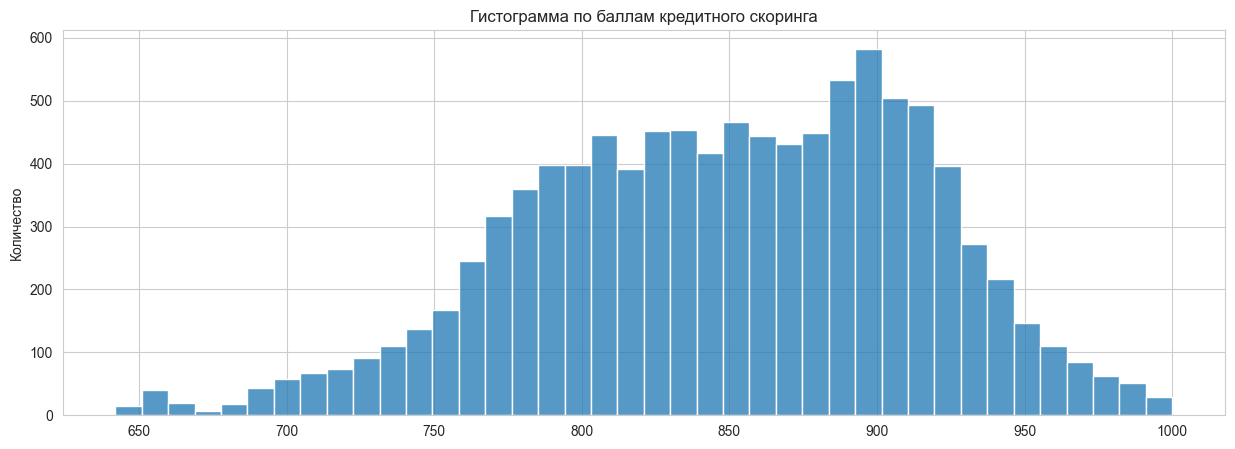

In [37]:
title = 'Гистограмма по баллам кредитного скоринга'
get_characteristic('score', title)

In [38]:
data.query('score < 700')['user_id'].count()

170

**Баланс на счёте**

count    7705.000000
mean        0.827794
std         1.980614
min         0.000000
25%         0.295554
50%         0.524272
75%         0.980706
max       119.113552
Name: balance_1, dtype: float64

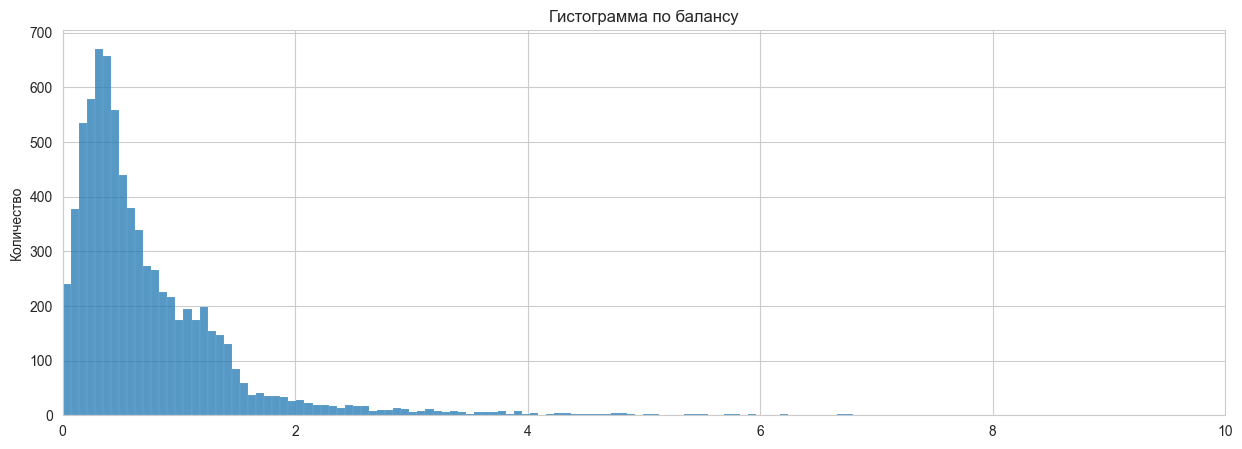

In [39]:
data['balance_1'] = data['balance'] / 1000000
title = 'Гистограмма по балансу'
get_characteristic('balance_1', title)

In [40]:
data.query('balance_1 > 100')['user_id'].count()

1

**Зарплата**

count    10000.000000
mean       147.866886
std        139.388511
min          2.546300
25%         75.251900
50%        119.658105
75%        174.500542
max       1395.064450
Name: est_salary_1, dtype: float64

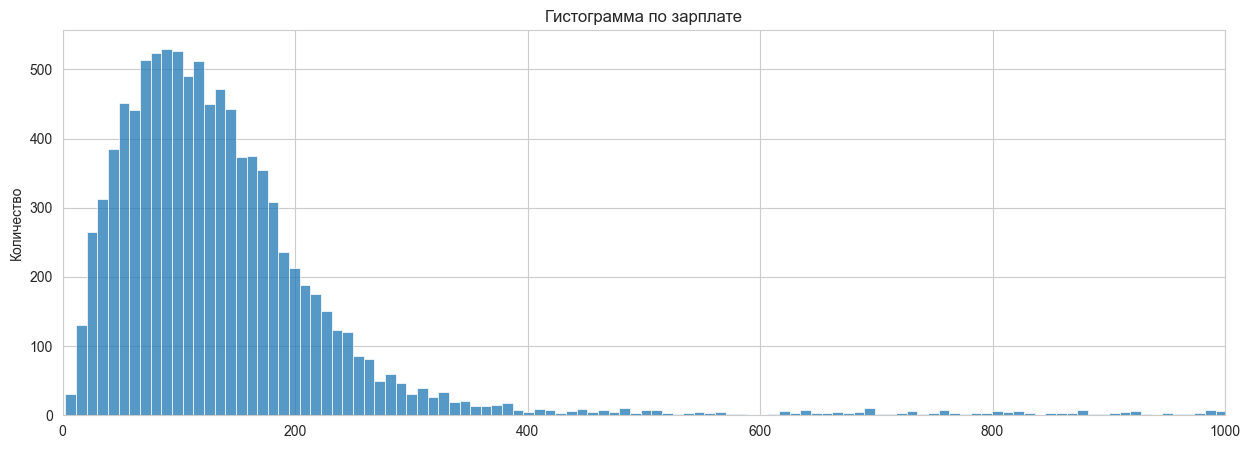

In [41]:
data['est_salary_1'] = data['est_salary'] / 1000
title = 'Гистограмма по зарплате'
get_characteristic('est_salary_1', title)

In [42]:
data.query('est_salary_1 > 1000')['user_id'].count()

59

**Возраст**

count    10000.000000
mean        42.729200
std         12.165355
min         18.000000
25%         33.000000
50%         40.000000
75%         51.000000
max         86.000000
Name: age, dtype: float64

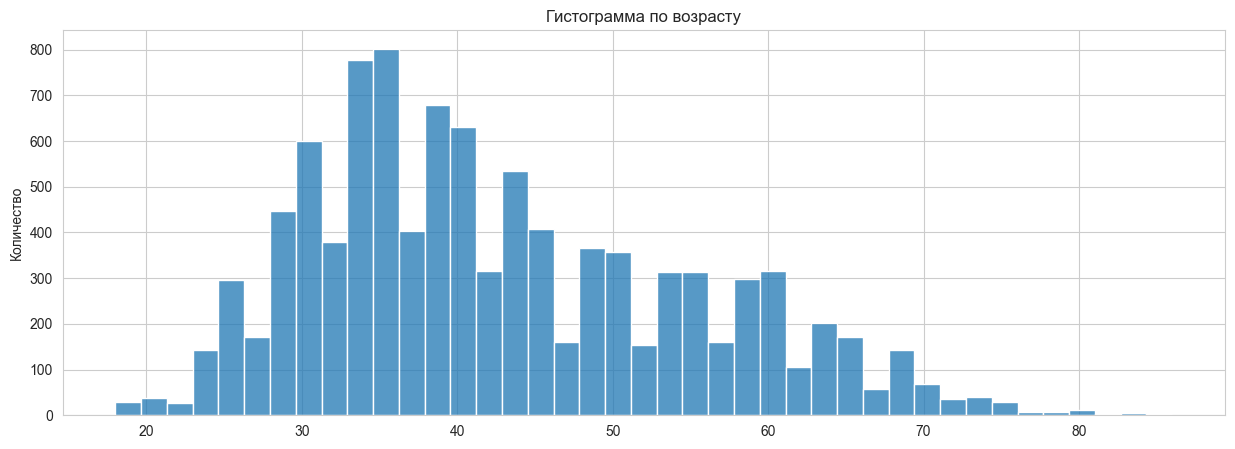

In [43]:
title = 'Гистограмма по возрасту'
get_characteristic('age', title)

In [44]:
data.query('age > 80')['user_id'].count()

13

In [45]:
data = data.query('products != 0')

**Наблюдения**:

- Аномально низких (отрицательных) значений, например, возраста, баланса или зарплаты - нет.
- У баланса и зарплаты очень длинные хвосты, много выбросов
- Два самых больших значения по объектам собственности - 8, 9 - в сумме таких пользователей всего 30.
- Максимальное кол-во продуктов, которые использует пользователь - 5, таких пользователей всего 19. Есть один пользователь, у которого 0 продуктов, с точки зрения анализа показателей банка он лишний, поэтому он был удален.

## Исследовательский анализ

Посмотрим на процентное разделение отточных и не отточных пользователей.

In [46]:
churn_grouped = data.groupby('churn', as_index=False).agg({'user_id':'count'}).rename(columns={'user_id':'users'})
churn_grouped.loc[churn_grouped['churn'] == 1, 'churn_str'] = 'Отточный'
churn_grouped.loc[churn_grouped['churn'] == 0, 'churn_str'] = 'Не отточный'
churn_grouped

churn  users    churn_str
0      0   8180  Не отточный
1      1   1819     Отточный

In [47]:
fig = go.Figure(data=[go.Pie(labels = churn_grouped['churn_str'], values=churn_grouped['users'])])

fig.update_layout(title='Доли отточности',
                 legend_title_text='Отточность')

fig.show()

18% отточных клиентов!

Для последующих аналитических манипуляций разделим датафрейм на два: отточный(churn) и не отточный(not_churn). 

In [48]:
churn = data.query('churn == 1')

churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1819 entries, 0 to 9994
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        1819 non-null   int64  
 1   score          1819 non-null   float64
 2   age            1819 non-null   int32  
 3   equity         1819 non-null   int64  
 4   balance        1807 non-null   float64
 5   products       1819 non-null   int64  
 6   credit_card    1819 non-null   int64  
 7   last_activity  1819 non-null   int64  
 8   est_salary     1819 non-null   float64
 9   churn          1819 non-null   int64  
 10  gender         1819 non-null   object 
 11  city           1819 non-null   object 
 12  is_female      1819 non-null   uint8  
 13  is_male        1819 non-null   uint8  
 14  is_Rostov      1819 non-null   uint8  
 15  is_Rybinsk     1819 non-null   uint8  
 16  is_Yaroslavl   1819 non-null   uint8  
 17  balance_1      1807 non-null   float64
 18  est_sala

In [49]:
not_churn = data.query('churn == 0')

not_churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8180 entries, 1 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        8180 non-null   int64  
 1   score          8180 non-null   float64
 2   age            8180 non-null   int32  
 3   equity         8180 non-null   int64  
 4   balance        5898 non-null   float64
 5   products       8180 non-null   int64  
 6   credit_card    8180 non-null   int64  
 7   last_activity  8180 non-null   int64  
 8   est_salary     8180 non-null   float64
 9   churn          8180 non-null   int64  
 10  gender         8180 non-null   object 
 11  city           8180 non-null   object 
 12  is_female      8180 non-null   uint8  
 13  is_male        8180 non-null   uint8  
 14  is_Rostov      8180 non-null   uint8  
 15  is_Rybinsk     8180 non-null   uint8  
 16  is_Yaroslavl   8180 non-null   uint8  
 17  balance_1      5898 non-null   float64
 18  est_sala

### Cравнение количественных портретов клиентов в разрезе оттока по всем показателям

Посмотрим на описательную статистику непрерывных и категориальных переменных.

**Непрерывные:** score, age, equity, products, balance_1, est_salary_1. 

**Категориальные в бинарном формате:** credit_card, last_activity, is_male, is_Rostov, is_Rybinsk, is_Yaroslavl.

In [50]:
# датафрейм с описательной статистикой по отточным пользователям
churn_df = churn.describe()
churn_df = churn_df.drop(['user_id', 'balance', 'est_salary', 'churn'], axis=1)
churn_df

score          age       equity     products  credit_card  \
count  1819.000000  1819.000000  1819.000000  1819.000000  1819.000000   
mean    863.346894    41.431556     3.764156     2.377130     0.551402   
std      49.571209    11.142003     1.586144     0.921951     0.497488   
min     706.000000    18.000000     0.000000     1.000000     0.000000   
25%     828.000000    32.000000     3.000000     2.000000     0.000000   
50%     866.000000    39.000000     4.000000     2.000000     1.000000   
75%     898.000000    52.000000     5.000000     3.000000     1.000000   
max    1000.000000    75.000000     9.000000     5.000000     1.000000   

       last_activity    is_female      is_male    is_Rostov   is_Rybinsk  \
count    1819.000000  1819.000000  1819.000000  1819.000000  1819.000000   
mean        0.702584     0.349643     0.650357     0.146234     0.239692   
std         0.457247     0.476988     0.476988     0.353438     0.427013   
min         0.000000     0.000000     0.000000     0.000000     0.000000   
25%         0.000000     0.000000     0.000000     0.000000     0.000000   
50%         1.000000     0.000000     1.000000     0.000000     0.000000   
75%         1.000000     1.000000     1.000000     0.000000     0.000000   
max         1.000000     1.000000     1.000000     1.000000     1.000000   

       is_Yaroslavl    balance_1  est_salary_1  
count   1819.000000  1807.000000   1819.000000  
mean       0.614074     1.133993    148.310728  
std        0.486947     2.033978    122.914344  
min        0.000000     0.000006     10.880270  
25%        0.000000     0.387218     83.196615  
50%        1.000000     0.782410    125.395220  
75%        1.000000     1.348101    175.985385  
max        1.000000    64.866210   1263.028490

In [51]:
# датафрейм с описательной статистикой по не отточным пользователям
not_churn_df = not_churn.describe()
not_churn_df = not_churn_df.drop(['user_id', 'balance', 'est_salary','churn'], axis=1)
not_churn_df

score          age       equity     products  credit_card  \
count  8180.000000  8180.000000  8180.000000  8180.000000  8180.000000   
mean    845.428362    43.013325     2.374817     1.757579     0.709169   
std      68.047721    12.357898     1.971394     0.713371     0.454174   
min     642.000000    18.000000     0.000000     1.000000     0.000000   
25%     796.000000    34.000000     0.000000     1.000000     0.000000   
50%     848.000000    40.000000     3.000000     2.000000     1.000000   
75%     900.000000    51.000000     4.000000     2.000000     1.000000   
max    1000.000000    86.000000     9.000000     5.000000     1.000000   

       last_activity    is_female      is_male    is_Rostov   is_Rybinsk  \
count    8180.000000  8180.000000  8180.000000  8180.000000  8180.000000   
mean        0.483741     0.532763     0.467237     0.140709     0.276039   
std         0.499766     0.498956     0.498956     0.347742     0.447064   
min         0.000000     0.000000     0.000000     0.000000     0.000000   
25%         0.000000     0.000000     0.000000     0.000000     0.000000   
50%         0.000000     1.000000     0.000000     0.000000     0.000000   
75%         1.000000     1.000000     1.000000     0.000000     1.000000   
max         1.000000     1.000000     1.000000     1.000000     1.000000   

       is_Yaroslavl    balance_1  est_salary_1  
count   8180.000000  5898.000000   8180.000000  
mean       0.583252     0.733983    147.783200  
std        0.493051     1.954573    142.802379  
min        0.000000     0.000000      2.546300  
25%        0.000000     0.279349     73.506152  
50%        1.000000     0.475382    118.257715  
75%        1.000000     0.853927    173.990125  
max        1.000000   119.113552   1395.064450

Для *непрерывных переменных* будем использовать *медиану*, для *категориальных - среднее*, т.к. они представлены в бинарном формате, поэтому будут отражать долю значений, принимающих единицу.

Напишем функцию для сравнения медианы, где индекс будет принимать значения "50%" либо "mean", столбец - параметр, значение которого будет сравнивать между отточным и не отточным датафреймами.

- на сколько процентов медианное значение отточной непрерывной переменной (is_category = False) больше медианного значения не отточной; 
- на сколько процентов среднее значение отточной бинарной переменной (is_category = True) больше среднего значения не отточной.

In [52]:
def get_percent_diff(parameters, is_category, dict_):
    if is_category:
        print(f'Сравнение категориальных переменных')
        print()
        for param in parameters:
            print(f'Сравнение среднего значения {param}')
            result = round(churn_df.loc['mean', param] / not_churn_df.loc['mean', param] * 100 - 100, 2)
            print(f'Разница составляет {result}%')
            print()
            dict_[param] = result
    else:
        print('Сравнение непрерывных переменных')
        print()
        for param in parameters:
            print(f'Сравнение медианного значения {param}')
            result = round(churn_df.loc['50%', param] / not_churn_df.loc['50%', param] * 100 - 100, 2)
            print(f'Разница составляет {result}%')
            print()
            dict_[param] = result            

In [53]:
cont_dict = {}
params = ['score','balance_1', 'est_salary_1', 'equity', 'products', 'age']
get_percent_diff(params, False, cont_dict)

Сравнение непрерывных переменных

Сравнение медианного значения score
Разница составляет 2.12%

Сравнение медианного значения balance_1
Разница составляет 64.59%

Сравнение медианного значения est_salary_1
Разница составляет 6.04%

Сравнение медианного значения equity
Разница составляет 33.33%

Сравнение медианного значения products
Разница составляет 0.0%

Сравнение медианного значения age
Разница составляет -2.5%



In [54]:
cont_df = pd.DataFrame(cont_dict, index=[0])
cont_df = cont_df.T.reset_index().rename(columns={0:'median', 'index':'parameter'})\
          .sort_values(by='median', ascending=False)
cont_df

parameter  median
1     balance_1   64.59
3        equity   33.33
2  est_salary_1    6.04
0         score    2.12
4      products    0.00
5           age   -2.50

In [55]:
category_dict = {}
params = ['last_activity','credit_card', 'is_male', 'is_female', 'is_Rostov', 'is_Rybinsk', 'is_Yaroslavl']
get_percent_diff(params, True, category_dict)

Сравнение категориальных переменных

Сравнение среднего значения last_activity
Разница составляет 45.24%

Сравнение среднего значения credit_card
Разница составляет -22.25%

Сравнение среднего значения is_male
Разница составляет 39.19%

Сравнение среднего значения is_female
Разница составляет -34.37%

Сравнение среднего значения is_Rostov
Разница составляет 3.93%

Сравнение среднего значения is_Rybinsk
Разница составляет -13.17%

Сравнение среднего значения is_Yaroslavl
Разница составляет 5.28%



In [56]:
category_df = pd.DataFrame(category_dict, index=[0])
category_df = category_df.T.reset_index().rename(columns={0:'mean', 'index':'parameter'})\
          .sort_values(by='mean', ascending=False)
category_df

parameter   mean
0  last_activity  45.24
2        is_male  39.19
6   is_Yaroslavl   5.28
4      is_Rostov   3.93
5     is_Rybinsk -13.17
1    credit_card -22.25
3      is_female -34.37

**Вывод**

Среди **отточных** преимущество имеют следующие признаки: 

 - баланс - разница составляет 64.59%, 
 - активность  - 45.24%
 - мужчины - 39.19%
 - кол-во баллов собственности - 33.33%
 - зарплата - 6.04%
 - Ярославль - 5.28%
 - Ростов - 3.93%
 - баллы кредитного скоринга - 2.12%
 
Среди **не отточных**:

 - женщины - 34.37%
 - наличие кредитной карты - 22.25%
 - Рыбинск - 13.17%
 - возраст - 2.5%

Продукты имеют разницу в 0% :).

**Точно влияют на отток: баланс, активность пользователей, кол-во баллов собственности - все эти переменные имееют преимущество более 30% относительно не отточных.** Также будем иметь в виду, что отточных пользователей больше в Ярославле и Ростове, и преимущественно это мужчины; **важным преимущественным признаком среди не отточных является наличие кредитной карты**.

### Распределение непрерывных переменных (в разрезе оттока)

Для переменных с большим количеством уникальных значений - balance, score, est_salary, age -  построим графики распределения с разрезом по отточности.

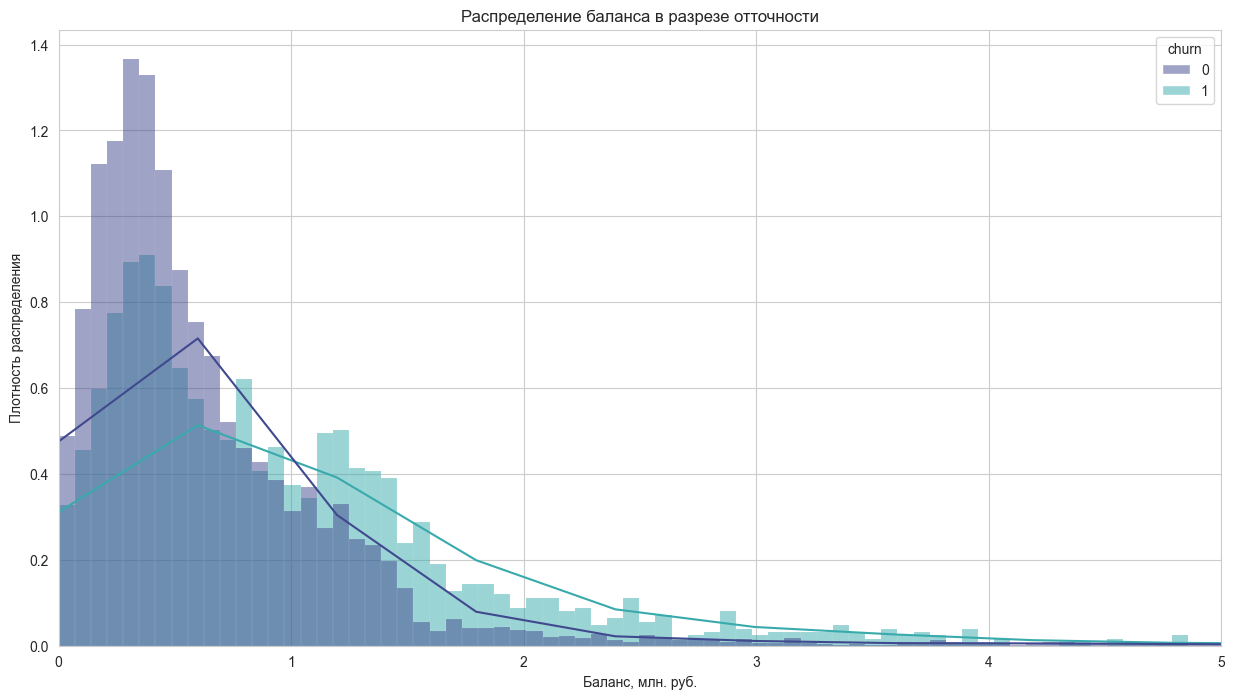

In [57]:
plt.figure(figsize=(15,8))

sns.histplot(x='balance_1', data=data, kde=True, hue='churn', palette='mako', stat="density", common_norm=False)
plt.title('Распределение баланса в разрезе отточности')
plt.xlim(0,5)
plt.ylabel('Плотность распределения')
plt.xlabel('Баланс, млн. руб.')
plt.show()

- Исходя из графика видно, что **начиная с 1 млн. на балансе отточность явно преобладает**. 
- **Не отточными** пользователями являются преимущественно те, у кого на балансе до 1 млн.

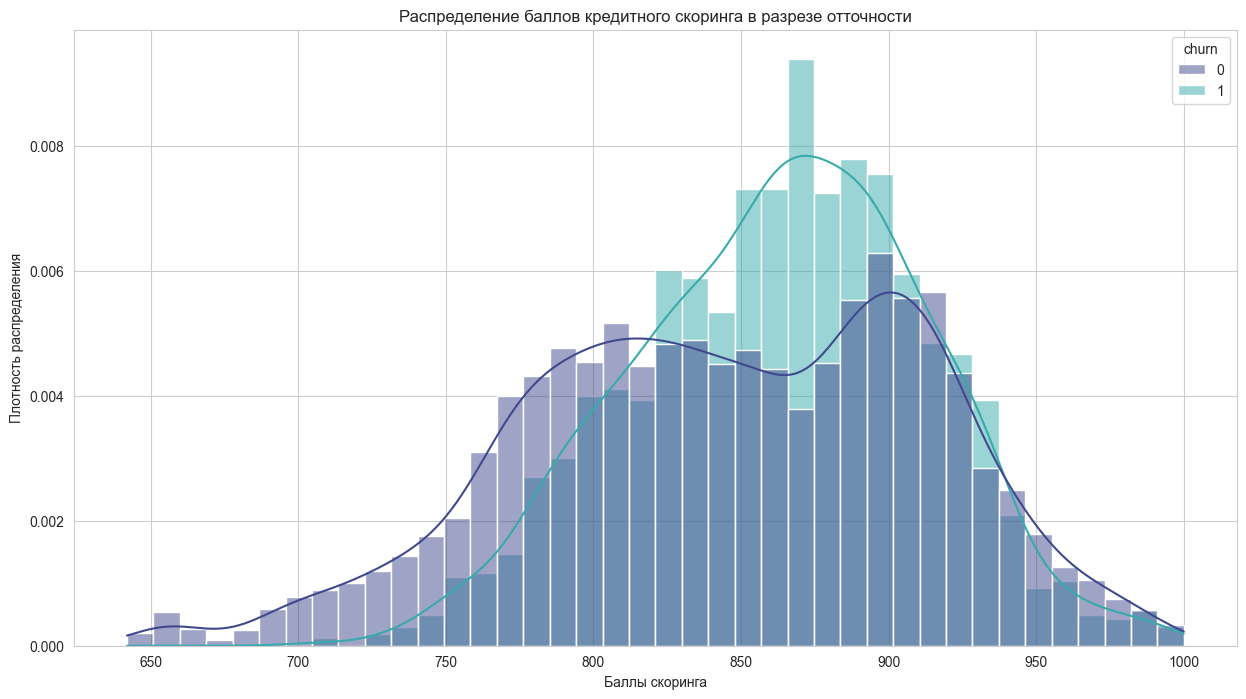

In [58]:
plt.figure(figsize=(15,8))

sns.histplot(x='score', data=data, kde=True, hue='churn', palette='mako', stat="density", common_norm=False)
plt.title('Распределение баллов кредитного скоринга в разрезе отточности')
plt.ylabel('Плотность распределения')
plt.xlabel('Баллы скоринга')
plt.show()

- Пик среди **отточных данных** приходится на **баллы скоринга в диапазоне от 830 до 940**.
- Среди **не отточных** можно выделить два диапазона: **от 650 до 800** и **от 900 до 1000** баллов.

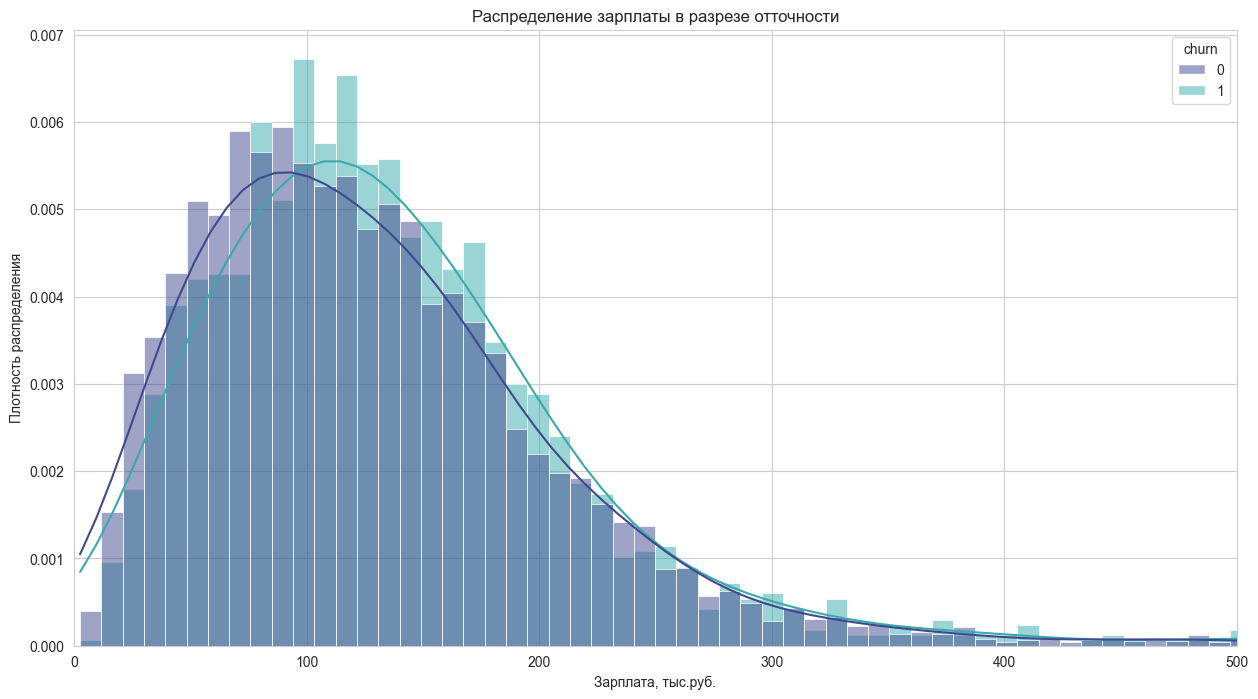

In [59]:
plt.figure(figsize=(15,8))

sns.histplot(x='est_salary_1', data=data, kde=True, hue='churn', palette='mako', stat="density", common_norm=False)
plt.title('Распределение зарплаты в разрезе отточности')
plt.xlim(0,500)
plt.ylabel('Плотность распределения')
plt.xlabel('Зарплата, тыс.руб.')
plt.show()

- Здесь **наблюдается минимальная разница**, чуть превосходят отточные клиенты с зарплатой в районе от 100 до 150 тыс. Однако я бы зафиксировала, что распределения идентичны.

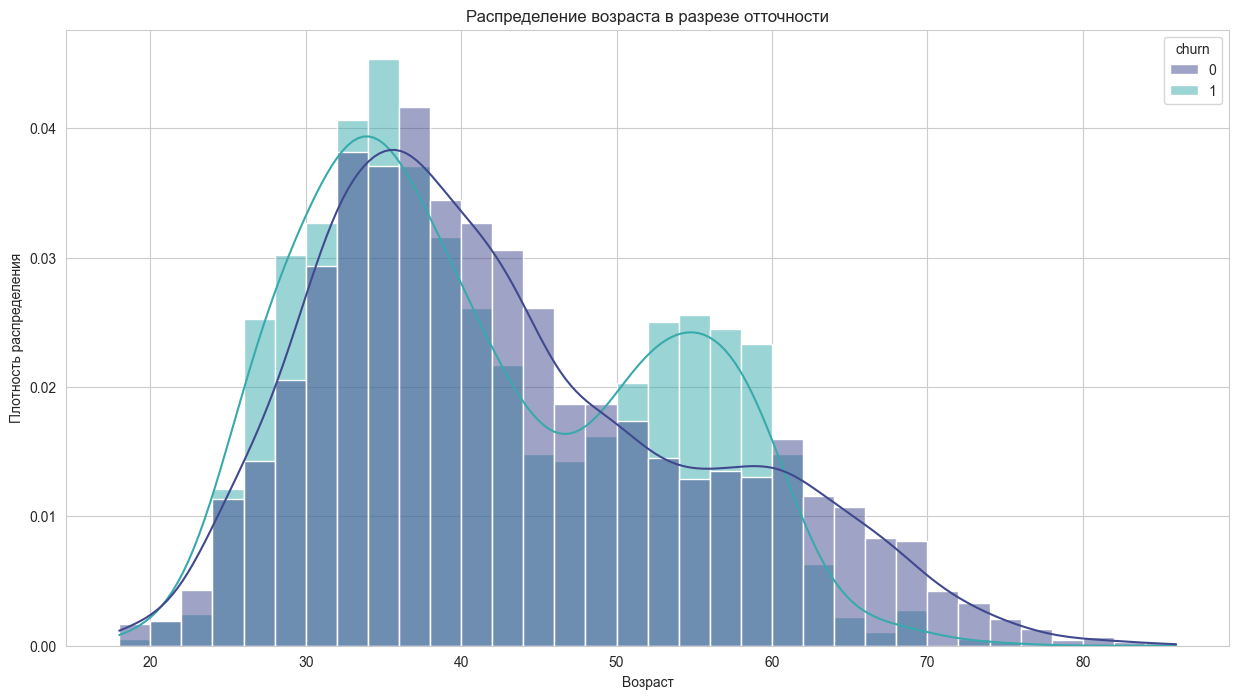

In [60]:
plt.figure(figsize=(15,8))

sns.histplot(x='age', data=data, kde=True, hue='churn', palette='mako', stat="density", common_norm=False, binwidth = 2)
plt.title('Распределение возраста в разрезе отточности')
plt.ylabel('Плотность распределения')
plt.xlabel('Возраст')
plt.show()

- Среди **отточных** наблюдается *два "колокола"* с небольшим преимуществом **в диапазоне от 20 до 35 лет** и с **бОльшим преимуществом в возрасте от 50 до 60 лет**.
- Среди **не отточных** пик и соответствующее преимущество приходится на диапазон **от 35 до 50 лет**, а также наблюдается маленький скачок **от 60 лет**.

**Вывод:**

Явно выраженные признаки **отточных** клиентов:
 - **баланс** больше 1 млн. руб;
 - наличие **баллов кредитного скоринга** в диапазоне от 800 до 900;
 - **возраст** в меньшей мере в диапазоне от 20 до 32 лет и в бОльшей мере - от 50 до 60 лет;
 - **заработная плата** у таких клиентов в диапазоне от 100 до 200 тыс. руб.
 
**Не отточными** пользователями являются преимущественно те, у кого *на балансе до 1 млн*, *со скорингом в диапазонах от 650 до 800 и от 900 до 1000 баллов*, *возрастом от 35 до 50 и от 60 лет*.     

### Анализ уровня оттока по категориям

- Сделаем группировку по *категориальными данными* - last_activity, credit_card, gender, city, и дополнительно *количественным данным* - products, equity с агрегированием по среднему в разрезе отточности.
- По сгруппированным данным построим столбчатые диаграммы с дополнительной информацией о среднем уровне оттока по банку.

In [61]:
# средний уровень оттока по банку
mean_churn = round(data['churn'].mean(), 3)
mean_churn

0.182

In [62]:
def get_grouped_tables(params):
    
    '''
    функция для формирования сводных таблиц по парметрам
    params - лист параметров
    '''
    
    tables = []
    for param in params:
        table = data.groupby(param, as_index=False).agg({'churn':['mean','count']})
        table.columns = [param, 'mean', 'count']
        table = table.sort_values(by='count', ascending=False)
        table['diff_per'] = round(table['mean'] - mean_churn, 2) * 100
        tables.append(table)
        
    return tables    

In [63]:
params = ['credit_card', 'last_activity','city', 'gender', 'products', 'equity']
tables = get_grouped_tables(params)

credit_card = tables[0]
last_activity = tables[1]
city = tables[2]
gender = tables[3]
products = tables[4]
equity = tables[5]

credit_card.loc[credit_card['credit_card'] == 0, 'credit_card'] = 'без кр. карты'
credit_card.loc[credit_card['credit_card'] == 1, 'credit_card'] = 'с кр. картой'

last_activity.loc[last_activity['last_activity'] == 0, 'last_activity'] = 'не активный'
last_activity.loc[last_activity['last_activity'] == 1, 'last_activity'] = 'активный'

In [64]:
credit_card

credit_card      mean  count  diff_per
1   с кр. картой  0.147413   6804      -3.0
0  без кр. карты  0.255399   3195       7.0

In [65]:
last_activity

last_activity      mean  count  diff_per
1      активный  0.244126   5235       6.0
0   не активный  0.113560   4764      -7.0

In [66]:
city

city      mean  count  diff_per
2  Ярославль  0.189708   5888       1.0
1    Рыбинск  0.161841   2694      -2.0
0     Ростов  0.187721   1417       1.0

In [67]:
gender

gender      mean  count  diff_per
1      М  0.236364   5005       5.0
0      Ж  0.127353   4994      -5.0

In [68]:
products

products      mean  count  diff_per
1         2  0.190987   5126       1.0
0         1  0.070338   3341     -11.0
2         3  0.285852   1039      10.0
3         4  0.632911    474      45.0
4         5  0.421053     19      24.0

In [69]:
equity

equity      mean  count  diff_per
0       0  0.034722   2592     -15.0
5       5  0.300834   1918      12.0
4       4  0.250811   1850       7.0
3       3  0.208171   1542       3.0
2       2  0.157795   1052      -2.0
1       1  0.120155    774      -6.0
6       6  0.360248    161      18.0
7       7  0.462500     80      28.0
8       8  0.352941     17      17.0
9       9  0.538462     13      36.0

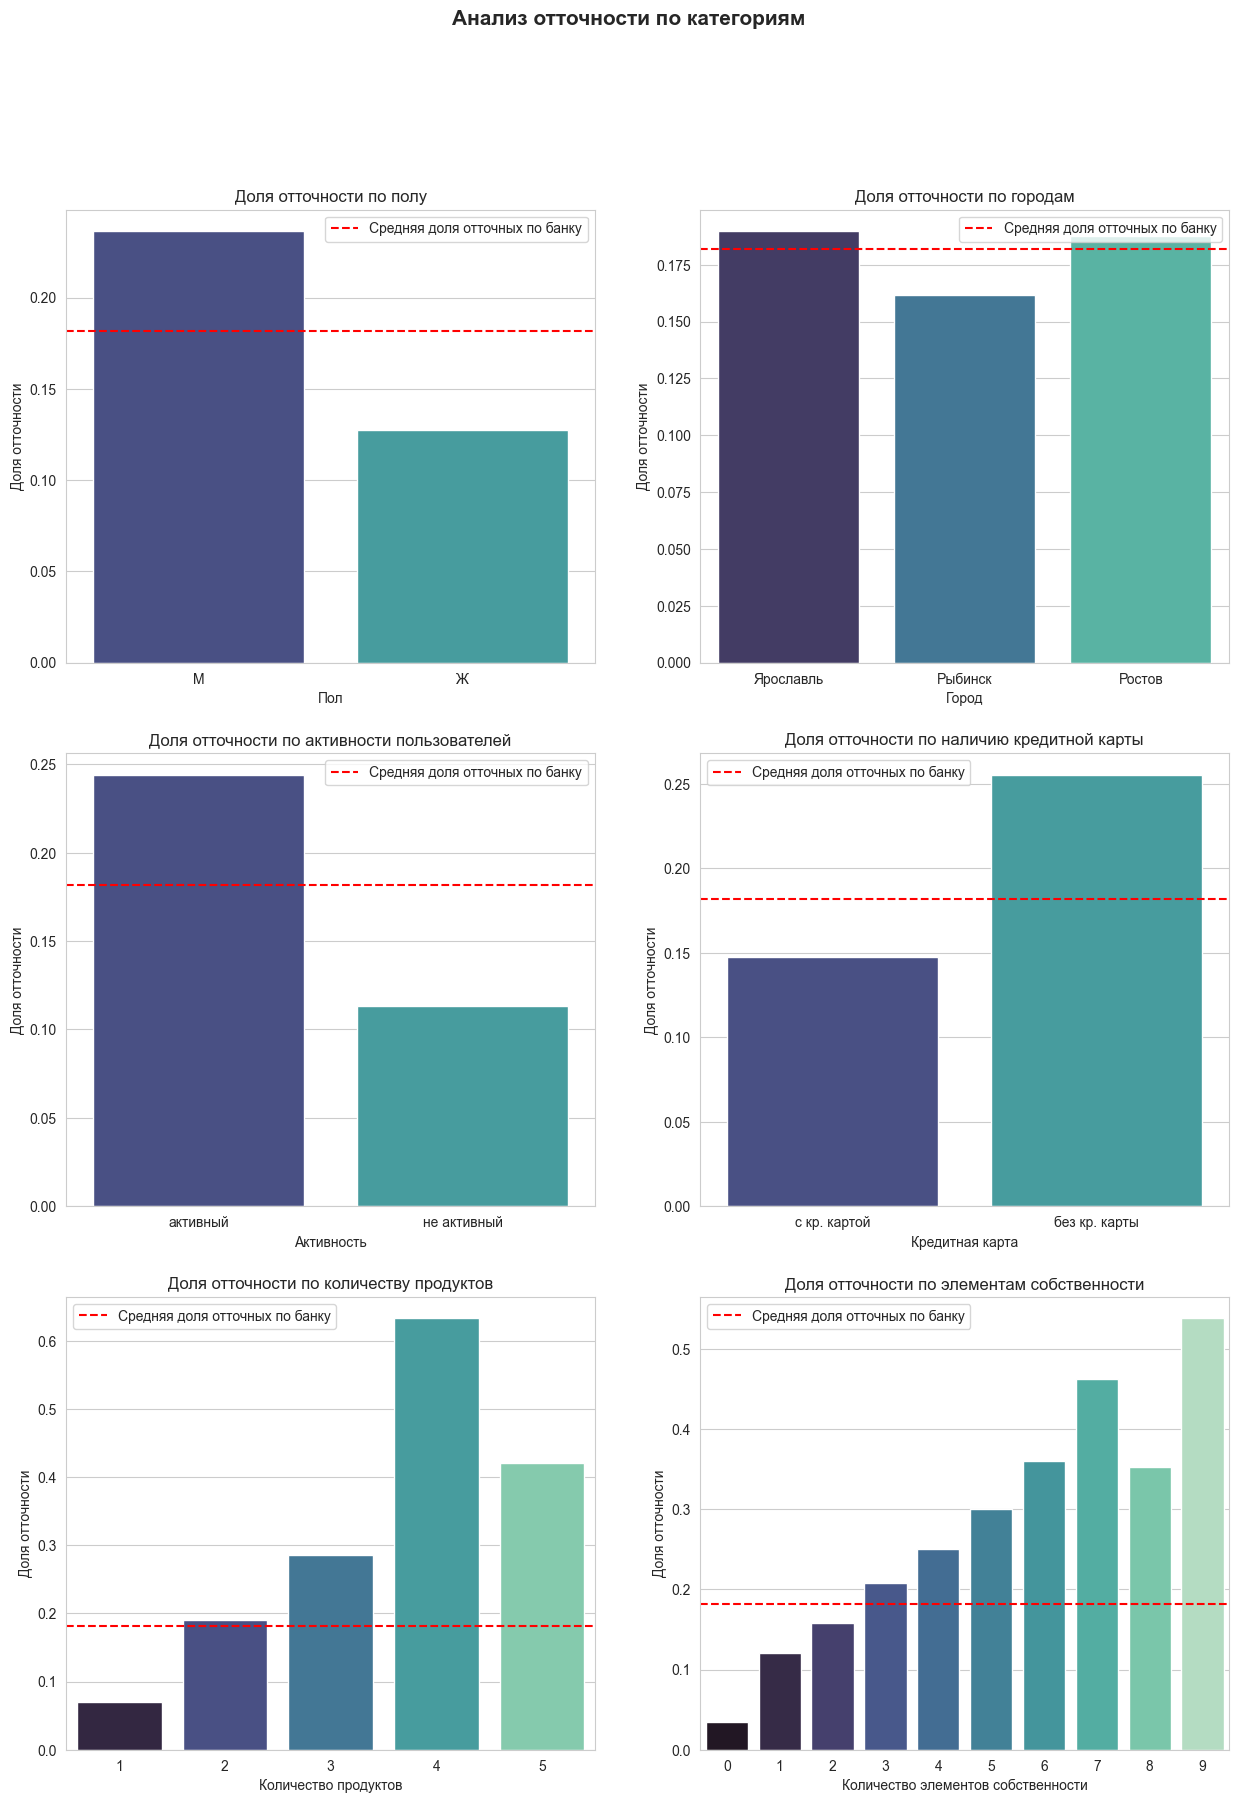

In [70]:
plt.figure(figsize=(15,20))

plt.suptitle('Анализ отточности по категориям', fontweight='bold', fontsize=15)
ax1 = plt.subplot(3,2,1)
sns.barplot(x='gender', y='mean', data=gender, palette='mako', ax=ax1)
plt.axhline(y=mean_churn, color='red', linestyle='--', label='Средняя доля отточных по банку')
plt.title('Доля отточности по полу')
plt.xlabel('Пол')
plt.ylabel('Доля отточности')
plt.legend()

ax2 = plt.subplot(3,2,2)
sns.barplot(x='city', y='mean', data=city, palette='mako', ax=ax2)
plt.axhline(y=mean_churn, color='red', linestyle='--', label='Средняя доля отточных по банку')
plt.title('Доля отточности по городам')
plt.xlabel('Город')
plt.ylabel('Доля отточности')
plt.legend()

ax3 = plt.subplot(3,2,3)
sns.barplot(x='last_activity', y='mean', data=last_activity, palette='mako', ax=ax3)
plt.axhline(y=mean_churn, color='red', linestyle='--', label='Средняя доля отточных по банку')
plt.title('Доля отточности по активности пользователей')
plt.xlabel('Активность')
plt.ylabel('Доля отточности')
plt.legend()

ax4 = plt.subplot(3,2,4)
sns.barplot(x='credit_card', y='mean', data=credit_card, palette='mako', ax=ax4)
plt.axhline(y=mean_churn, color='red', linestyle='--', label='Средняя доля отточных по банку')
plt.title('Доля отточности по наличию кредитной карты')
plt.xlabel('Кредитная карта')
plt.ylabel('Доля отточности')
plt.legend()

ax5 = plt.subplot(3,2,5)
sns.barplot(x='products', y='mean', data=products, palette='mako', ax=ax5)
plt.axhline(y=mean_churn, color='red', linestyle='--', label='Средняя доля отточных по банку')
plt.title('Доля отточности по количеству продуктов')
plt.xlabel('Количество продуктов')
plt.ylabel('Доля отточности')
plt.legend()

ax6 = plt.subplot(3,2,6)
sns.barplot(x='equity', y='mean', data=equity, palette='mako', ax=ax6)
plt.axhline(y=mean_churn, color='red', linestyle='--', label='Средняя доля отточных по банку')
plt.title('Доля отточности по элементам собственности')
plt.xlabel('Количество элементов собственности')
plt.ylabel('Доля отточности')
plt.legend()

plt.show()

**Вывод:**

Параметры, **превышающие среднее значение отточных по банку**:
- **мужчины** (на 5%)
- **активные пользователи** (на 6%)
- пользователи **без кредитной карты** (на 7%) 
- пользователи, пользующиеся **двумя и более продуктами**: чем больше продуктов, тем выше отточность. Пользователи с 2-мя продуктами превышают среднее отточное значение на 1%, с 3-мя - на 10%, **с 4-мя - на 45%** (!), с 5-ю - на 24%.
- пользователи с **тремя и более элементами собственности** (от 3% до 36%): чем больше элементов собственности, тем выше отточность, больше остальные превышают среднее отточное значение пользователи с 9-ю эл. собственности - на 36%.
- пользователи из **Ярославля и Ростова** превышают среднее отточное значение по банку **всего на 1%**.

Дополнительно стоит учитывать, что с ростом количества продуктов и эл. собственности уменьшается кол-во пользователей, соответственно рассчитываемые доли там выше.

### Корреляционный анализ

In [71]:
data_1 = data.drop(['user_id', 'city', 'gender', 'balance', 'est_salary'], axis=1)
data_1.rename(columns={'balance_1' :'balance',
                      'est_salary_1':'est_salary'}, inplace = True)

interval_cols = ['score', 'age', 'equity', 'balance', 'products', 'credit_card', 
                 'last_activity', 'est_salary', 'churn', 'is_female', 'is_male', 
                 'is_Rostov', 'is_Rybinsk', 'is_Yaroslavl', 'balance', 'est_salary']
churn_phik = data_1.phik_matrix(interval_cols=interval_cols)

churn_phik.round(2)

score   age  equity  products  credit_card  last_activity  \
score           1.00  0.04    0.53      0.42         0.21           0.05   
age             0.04  1.00    0.04      0.14         0.16           0.09   
equity          0.53  0.04    1.00      0.58         0.22           0.05   
products        0.42  0.14    0.58      1.00         0.27           0.11   
credit_card     0.21  0.16    0.22      0.27         1.00           0.05   
last_activity   0.05  0.09    0.05      0.11         0.05           1.00   
churn           0.23  0.18    0.35      0.26         0.20           0.26   
is_female       0.07  0.29    0.06      0.07         0.20           0.01   
is_male         0.07  0.29    0.06      0.07         0.20           0.01   
is_Rostov       0.09  0.07    0.07      0.05         0.15           0.00   
is_Rybinsk      0.03  0.06    0.00      0.08         0.08           0.07   
is_Yaroslavl    0.08  0.10    0.05      0.11         0.18           0.08   
balance         0.17  0.03    0.00      0.00         0.00           0.00   
est_salary      0.40  0.36    0.29      0.22         0.04           0.05   

               churn  is_female  is_male  is_Rostov  is_Rybinsk  is_Yaroslavl  \
score           0.23       0.07     0.07       0.09        0.03          0.08   
age             0.18       0.29     0.29       0.07        0.06          0.10   
equity          0.35       0.06     0.06       0.07        0.00          0.05   
products        0.26       0.07     0.07       0.05        0.08          0.11   
credit_card     0.20       0.20     0.20       0.15        0.08          0.18   
last_activity   0.26       0.01     0.01       0.00        0.07          0.08   
churn           1.00       0.22     0.22       0.00        0.05          0.03   
is_female       0.22       1.00     1.00       0.02        0.02          0.04   
is_male         0.22       1.00     1.00       0.02        0.02          0.04   
is_Rostov       0.00       0.02     0.02       1.00        0.38          0.69   
is_Rybinsk      0.05       0.02     0.02       0.38        1.00          0.91   
is_Yaroslavl    0.03       0.04     0.04       0.69        0.91          1.00   
balance         0.02       0.05     0.05       0.00        0.02          0.05   
est_salary      0.05       0.14     0.14       0.14        0.10          0.18   

               balance  est_salary  
score             0.17        0.40  
age               0.03        0.36  
equity            0.00        0.29  
products          0.00        0.22  
credit_card       0.00        0.04  
last_activity     0.00        0.05  
churn             0.02        0.05  
is_female         0.05        0.14  
is_male           0.05        0.14  
is_Rostov         0.00        0.14  
is_Rybinsk        0.02        0.10  
is_Yaroslavl      0.05        0.18  
balance           1.00        0.37  
est_salary        0.37        1.00

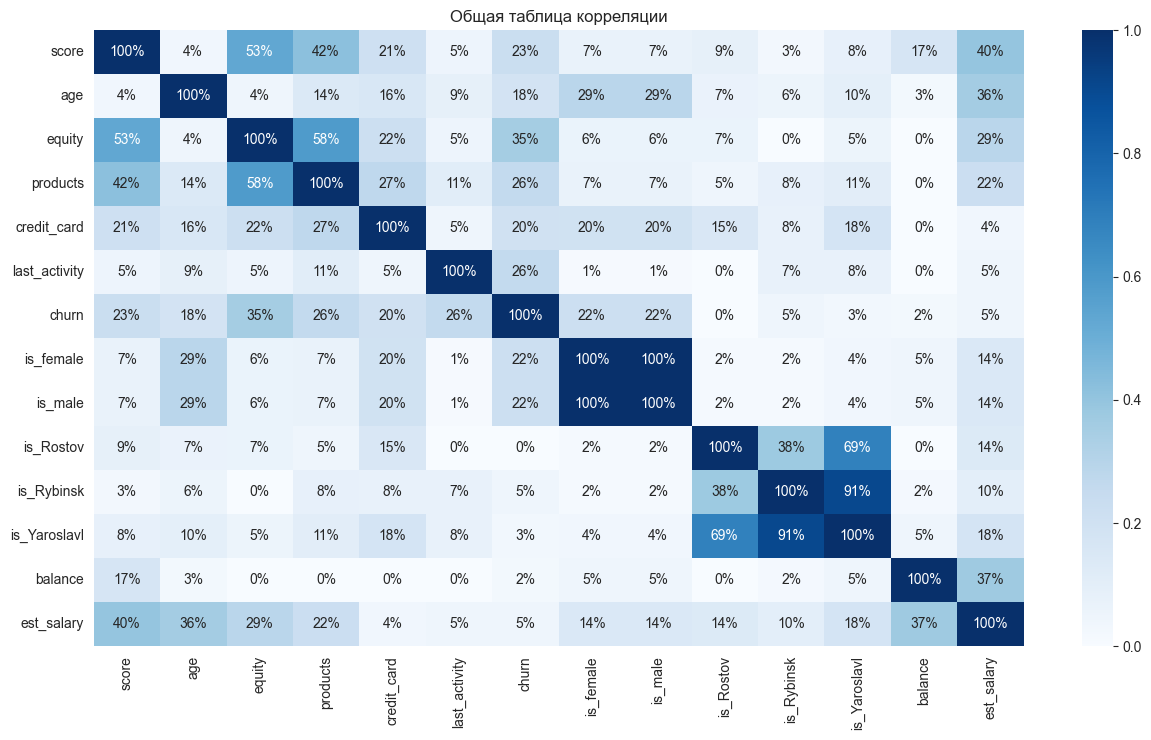

In [72]:
plt.figure(figsize=(15,8))

sns.heatmap(churn_phik, cmap="Blues", annot=True, fmt=".0%")
plt.title('Общая таблица корреляции')

plt.show()

Выделим отдельно столбец по отточности.

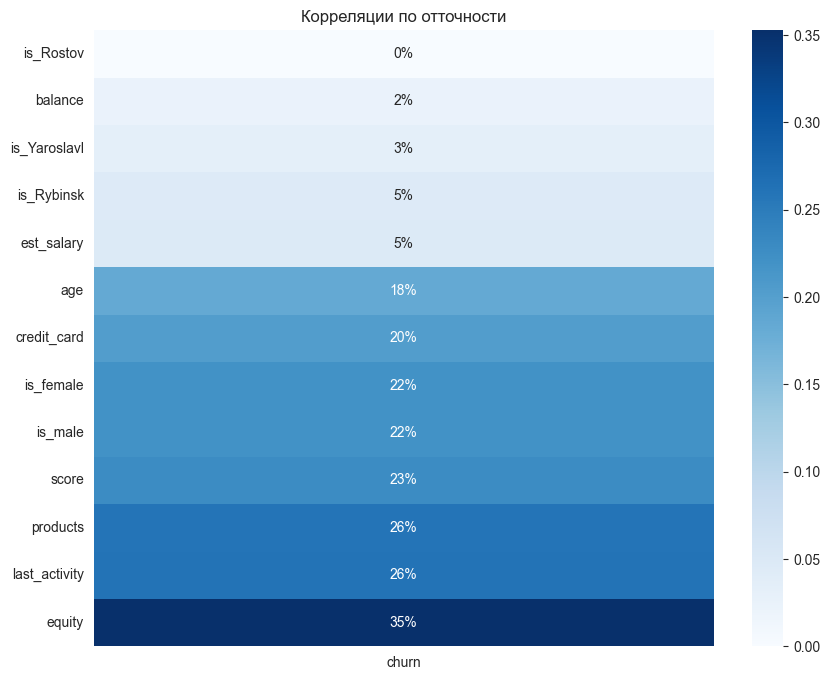

In [73]:
plt.figure(figsize=(10,8))

sns.heatmap(churn_phik.loc[:,['churn']].drop('churn').sort_values('churn'), cmap="Blues", annot=True, fmt=".0%")
plt.title('Корреляции по отточности')

plt.show()

Согласно шкале Чеддока показатель корреляции **от 10 до 30%** характеризуют **слабую связь**, **от 30 до 50% - умеренную**, **от 50 до 70% - заметную**, **от 70 до 90% высокую**, **от 90 до 100% - самую сильную**. Следовательно, можно сделать следующие выводы:
- отточность **очень слабо** зависит от **городов (0% - 5%)**, **балансового счета (2%)** и **заработной платы (5%)**; 
- **слабая связь** формируется от **возраста (18%)**, наличия **кредитной карты (20%)**, **пола (одинаковая зависимости в 22%)**, **кредитного скоринга (23%)**, **количества продуктов (26%)** и **активности пользователей (26%)**;
- **умеренная зависимость в 35%** формируется с **элементами собственности**.


Благодаря изученным в пункте 2.2 распределениям известно, что **начиная с 1 млн. на балансе отточность явно преобладает** и видеть в корреляционной зависимости баланс с 2% - странно. Воспользуемся методом pd.qсut и разделим данные по балансу на 8 интервалов (процентилей) и повторно построим корреляционные таблицы.

In [74]:
data_1['balance_bins'] = pd.qcut(x=data_1['balance'], q=8, precision=0)

data_1['balance_bins'].value_counts()

(-0.1, 0.2]     964
(0.2, 0.3]      963
(0.3, 0.4]      963
(0.4, 0.5]      963
(0.5, 0.7]      963
(0.7, 1.0]      963
(1.0, 1.4]      963
(1.4, 119.1]    963
Name: balance_bins, dtype: int64

In [75]:
interval_cols = ['score', 'age', 'equity', 'balance', 'products', 'credit_card', 
                 'last_activity', 'est_salary', 'churn', 'is_female', 'is_male', 
                 'is_Rostov', 'is_Rybinsk', 'is_Yaroslavl', 'balance', 'est_salary']
churn_phik = data_1.phik_matrix(interval_cols=interval_cols)

churn_phik.round(2)

score   age  equity  products  credit_card  last_activity  \
score           1.00  0.04    0.53      0.42         0.21           0.05   
age             0.04  1.00    0.04      0.14         0.16           0.09   
equity          0.53  0.04    1.00      0.58         0.22           0.05   
products        0.42  0.14    0.58      1.00         0.27           0.11   
credit_card     0.21  0.16    0.22      0.27         1.00           0.05   
last_activity   0.05  0.09    0.05      0.11         0.05           1.00   
churn           0.23  0.18    0.35      0.26         0.20           0.26   
is_female       0.07  0.29    0.06      0.07         0.20           0.01   
is_male         0.07  0.29    0.06      0.07         0.20           0.01   
is_Rostov       0.09  0.07    0.07      0.05         0.15           0.00   
is_Rybinsk      0.03  0.06    0.00      0.08         0.08           0.07   
is_Yaroslavl    0.08  0.10    0.05      0.11         0.18           0.08   
balance         0.17  0.03    0.00      0.00         0.00           0.00   
est_salary      0.40  0.36    0.29      0.22         0.04           0.05   
balance_bins    0.41  0.26    0.49      0.19         0.22           0.00   

               churn  is_female  is_male  is_Rostov  is_Rybinsk  is_Yaroslavl  \
score           0.23       0.07     0.07       0.09        0.03          0.08   
age             0.18       0.29     0.29       0.07        0.06          0.10   
equity          0.35       0.06     0.06       0.07        0.00          0.05   
products        0.26       0.07     0.07       0.05        0.08          0.11   
credit_card     0.20       0.20     0.20       0.15        0.08          0.18   
last_activity   0.26       0.01     0.01       0.00        0.07          0.08   
churn           1.00       0.22     0.22       0.00        0.05          0.03   
is_female       0.22       1.00     1.00       0.02        0.02          0.04   
is_male         0.22       1.00     1.00       0.02        0.02          0.04   
is_Rostov       0.00       0.02     0.02       1.00        0.38          0.69   
is_Rybinsk      0.05       0.02     0.02       0.38        1.00          0.91   
is_Yaroslavl    0.03       0.04     0.04       0.69        0.91          1.00   
balance         0.02       0.05     0.05       0.00        0.02          0.05   
est_salary      0.05       0.14     0.14       0.14        0.10          0.18   
balance_bins    0.31       0.11     0.11       0.09        0.01          0.09   

               balance  est_salary  balance_bins  
score             0.17        0.40          0.41  
age               0.03        0.36          0.26  
equity            0.00        0.29          0.49  
products          0.00        0.22          0.19  
credit_card       0.00        0.04          0.22  
last_activity     0.00        0.05          0.00  
churn             0.02        0.05          0.31  
is_female         0.05        0.14          0.11  
is_male           0.05        0.14          0.11  
is_Rostov         0.00        0.14          0.09  
is_Rybinsk        0.02        0.10          0.01  
is_Yaroslavl      0.05        0.18          0.09  
balance           1.00        0.37          0.09  
est_salary        0.37        1.00          0.30  
balance_bins      0.09        0.30          1.00

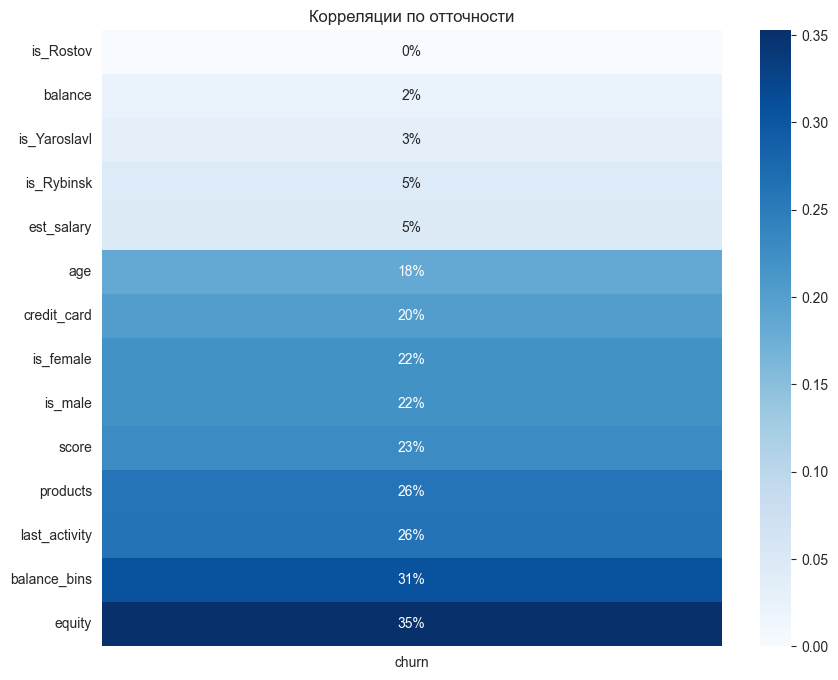

In [76]:
plt.figure(figsize=(10,8))

sns.heatmap(churn_phik.loc[:,['churn']].drop('churn').sort_values('churn'), cmap="Blues", annot=True, fmt=".0%")
plt.title('Корреляции по отточности')

plt.show()

Как и предпологалось, по **балансу** наблюдается **умеренная зависимость в 31%**. 

### Общий вывод


**1) Портреты пользователей**

**Точно влияют на отток: баланс, активность пользователей, кол-во баллов собственности - все эти переменные имееют преимущество более 30% относительно не отточных.** Также будем иметь в виду, что отточных пользователей больше в Ярославле и Ростове, и преимущественно это мужчины; **важным преимущественным признаком среди не отточных является наличие кредитной карты**.

**2) Распределение непрерывных**
  - баланс: **начиная с 1 млн. отточность явно преобладает**, **не отточными** пользователями являются преимущественно те, у кого на балансе до 1 млн;
  - кредитный скоринг: **отточные пользователи** имеют баллы скоринга в диапазоне **от 830 до 940**, **не отточные** - **от 650 до 800** и **от 900 до 1000** баллов.
  - зарплата: по графики распределения почти идентичны (необходима проверка стат. гипотезы)
  - возраст: среди **отточных** наблюдается *два "колокола"* с небольшим преимуществом **в диапазоне от 20 до 35 лет** (можно дополнительно провести проверку стат. гипотезы) и с **бОльшим преимуществом в возрасте от 50 до 60 лет**. Среди **не отточных** -  **от 35 до 50 лет**, а также наблюдается маленький скачок **от 60 лет**.

**3) Уровень оттока по категориям**

 Параметры, **превышающие среднее значение отточных по банку**:
- **мужчины** (на 5%)
- **активные пользователи** (на 6%)
- пользователи **без кредитной карты** (на 7%) 
- пользователи, пользующиеся **двумя и более продуктами**: чем больше продуктов, тем выше отточность. Пользователи с 2-мя продуктами превышают среднее отточное значение на 1%, с 3-мя - на 10%, **с 4-мя - на 45%** (!), с 5-ю - на 24%.
- пользователи с **тремя и более элементами собственности** (от 3% до 36%): чем больше элементов собственности, тем выше отточность, больше остальные превышают среднее отточное значение пользователи с 9-ю эл. собственности - на 36%.
- пользователи из **Ярославля и Ростова** превышают среднее отточное значение по банку **всего на 1%**.

**4) Корреляционный анализ**

- отточность **очень слабо** зависит от **городов (0% - 5%)**, **заработной платы (5%)**; 
- **слабая связь** формируется от **возраста (18%)**, наличия **кредитной карты (20%)**, **пола (одинаковая зависимости в 22%)**, **кредитного скоринга (23%)**, **количества продуктов (26%)** и **активности пользователей (26%)**;
- **умеренная зависимость в 35%** формируется с **элементами собственности** и в **31% с балансом**.


Далее необходимо будет провести проверку статистических гипотез, чтобы подтвердить или опровергнуть разницу между отточными и не отточными клиентами по следующим показателям:
 - Зарплата. Так как график плотности распределения показал минимальную разницу.
 - Возраст в диапазоне от 20 до 35 лет. График плотности рапределения в этом диапазоне также показал минимальную разницу.
 - Продукты. Наличие двух продуктов является более отточным или не отточным показателем?
 - Города. Ярославль и Ростов имеют отточность выше средней по банку, однако разница составляет один процент.

## Проверка статистических гипотез

### Гипотеза о равенстве среднего дохода отточных и не отточных клиентов

Для проверки данной гипотезы будет использоваться метод scipy.stats.ttest_ind().

- Н0 - средний доход отточных клиентов равен среднему доходу не отточных клиентов
- Н1 - средний доход отточных клиентов не равен среднему доходу не отточных клиентов

In [77]:
churn_salary = churn['est_salary_1']
not_churn_salary = not_churn['est_salary_1']
print(f'Длина выборки по отточным пользователям {len(churn_salary)}')
print(f'Длина выборки по не отточным пользователям {len(not_churn_salary)}')

Длина выборки по отточным пользователям 1819
Длина выборки по не отточным пользователям 8180


Выборки разного размера, поэтому дополнительно укажем параметр equal_var=False

In [78]:
alpha = 0.05

salary_result = st.ttest_ind(churn_salary, not_churn_salary, equal_var=False)
print('p-value', salary_result.pvalue)
if (salary_result.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-value 0.8724727072323828
Не отвергаем нулевую гипотезу


Согласно проведенному тесту, **гипотеза о равенстве зарплат** отточных и не отточных пользователей **не отвергается**.

Проверим распределение зарплат на нормальность.

In [79]:
alpha = 0.05  # критический уровень статистической значимости

print('Проверка на нормальность распределения отточных зарплат')
results = st.shapiro(churn_salary)
p_value = results[1]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')
    
print()
print('Проверка на нормальность распределения не отточных зарплат')
results = st.shapiro(not_churn_salary)
p_value = results[1]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')    

Проверка на нормальность распределения отточных зарплат
p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально

Проверка на нормальность распределения не отточных зарплат
p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


Распределения зарплат среди отточных и не отточных пользователей не имеют нормального распределения. Для того, чтобы t-test отрабатывал корректно, нам необходимо, **чтобы распределение средних было нормальным**.

Выполним непараметрический тест Манна-Уитни.

In [80]:
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(churn_salary, not_churn_salary)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.0002116065220362306
Отвергаем нулевую гипотезу: разница статистически значима


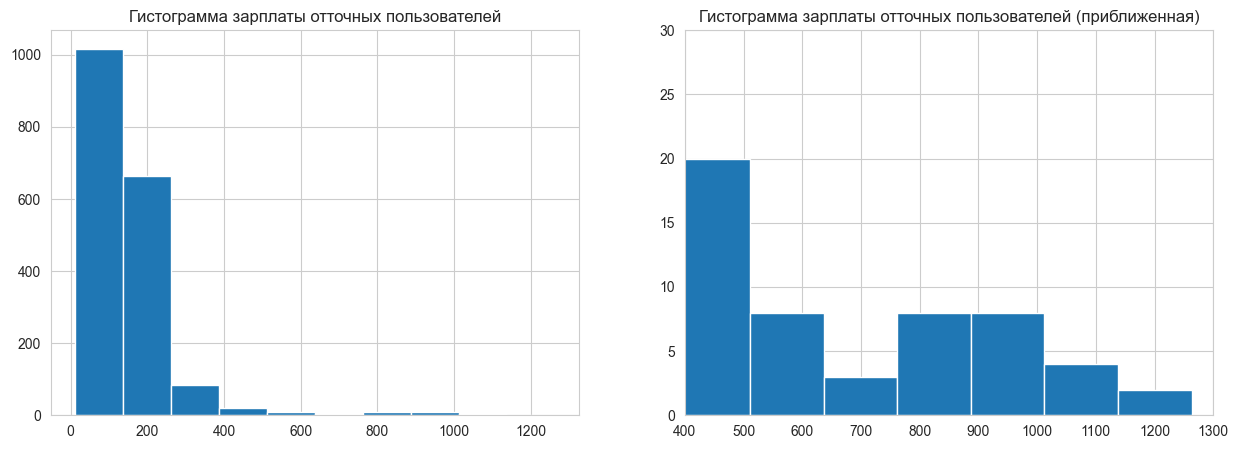

In [81]:
plt.figure(figsize=(15,5))

ax1 = plt.subplot(1,2,1)
churn['est_salary_1'].hist(ax=ax1)
plt.title('Гистограмма зарплаты отточных пользователей')

ax2 = plt.subplot(1,2,2)
churn['est_salary_1'].hist(ax=ax2)
plt.title('Гистограмма зарплаты отточных пользователей (приближенная)')
plt.xlim(400,1300)
plt.ylim(0,30)

plt.show()

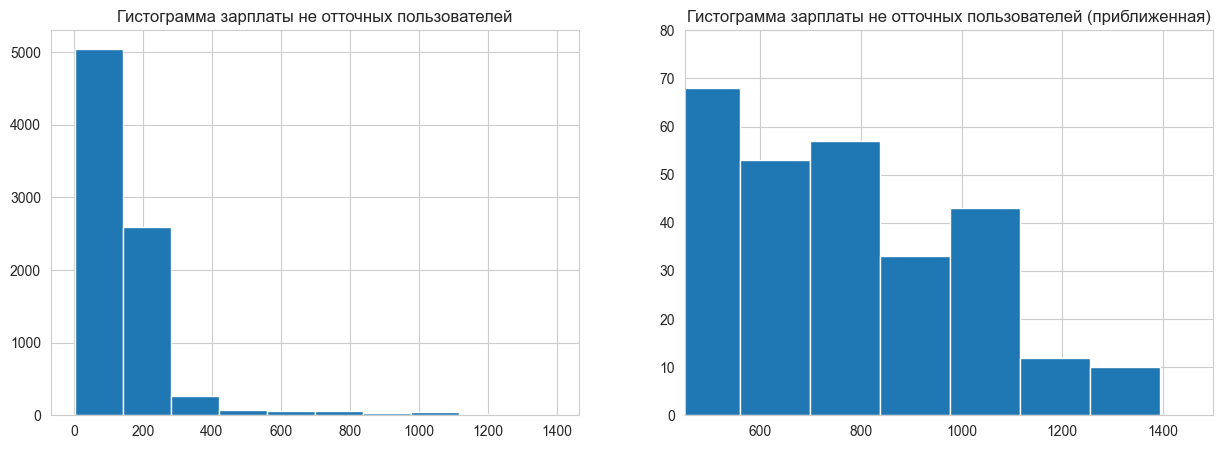

In [82]:
plt.figure(figsize=(15,5))

ax1 = plt.subplot(1,2,1)
not_churn['est_salary_1'].hist(ax=ax1)
plt.title('Гистограмма зарплаты не отточных пользователей')

ax2 = plt.subplot(1,2,2)
not_churn['est_salary_1'].hist(ax=ax2)
plt.title('Гистограмма зарплаты не отточных пользователей (приближенная)')
plt.xlim(450,1500)
plt.ylim(0,80)

plt.show()

Непараметрический тест дал результат, который **отвергает гипотезу о равенстве зарплат отточных и не отточных пользоваталей**. Если посмотреть на мини-гистограммы действительно заметна разница в количестве выбросов - у не отточных пользователей их больше. 

**Вывод:** в данном случае бОльший вес имеет результат теста Манна-Уитни, выбросы влияют на результативность - **между зарплатой отточных и не отточных пользователей есть разница**, будем учитывать это при сегментации.

### Гипотеза о равенстве возрастных долей среди отточных и не отточных пользователей.

На графике распределения в разрезе отточности наблюдается маленькая разница в диапазоне от 20 до 35 лет. Проверим наличие разницы при помощи z-теста.

- Н0 - статистически значимых различий между долями нет.
- Н1 - между долями присутствуют статистически значимые различия.

In [83]:
churn_len = len(churn['age'])
not_churn_len = len(not_churn['age'])

churn_products_count = churn.query('age >= 20 and age <= 35')['age'].count()
not_churn_products_count = not_churn.query('age >= 20 and age <= 35')['age'].count()

p1 = churn_products_count/churn_len
p2 = not_churn_products_count/not_churn_len

difference = p1 - p2 

# пропорция успехов в комбинированном датасете:
p_combined = (churn_products_count + not_churn_products_count) / (churn_len + not_churn_len)

z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/churn_len+ 1/not_churn_len))

distr = st.norm(0, 1)

p_value = round((1 - distr.cdf(abs(z_value))) * 2,3)

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными' ) 

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


**Вывод:** результат теста показал, что **между долями** отточных и не отточных пользователей в возрасте от 20 до 35 лет **есть статистически значимая разница**.

### Гипотеза о продуктах: равенство долей отточных и не отточных пользователей с двумя продуктами.

При проведении анализа уровня оттока по категориям на графике с продуктами линия средней доли оттока по банку прошла очень близко со столбиком с двумя продуктами. Необходимо проверить, является ли наличие двух продуктов статистически значимым показателем отточности.

- Н0 - статистически значимых различий между долями нет.
- Н1 - между долями присутствуют статистически значимые различия.

In [84]:
churn_len = len(churn['products'])
not_churn_len = len(not_churn['products'])

churn_products_count = churn.query('products == 2')['products'].count()
not_churn_products_count = not_churn.query('products == 2')['products'].count()

p1 = churn_products_count/churn_len
p2 = not_churn_products_count/not_churn_len

difference = p1 - p2 

# пропорция успехов в комбинированном датасете:
p_combined = (churn_products_count + not_churn_products_count) / (churn_len + not_churn_len)

z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/churn_len+ 1/not_churn_len))

distr = st.norm(0, 1)

p_value = round((1 - distr.cdf(abs(z_value))) * 2,3)

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными' ) 

p-значение:  0.016
Отвергаем нулевую гипотезу: между долями есть значимая разница


**Вывод:** **между долями** отточных и не отточных пользователей с двумя продуктами **есть статистически значимая разница**.

### Гипотеза о городах: равенство долей отточных и не отточных пользователей в Ярославле и Ростове.

In [85]:
def get_city_test_result(city):
    # размеры выборок
    n1 = len(churn[city])
    n2 = len(not_churn[city])

    # пропорции успехов
    p1 = churn[city].mean()
    p2 = not_churn[city].mean()

    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (churn[city].sum() + not_churn[city].sum()) / (n1 + n2)
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/n1+ 1/n2))

    distr = st.norm(0, 1)

    p_value = round((1 - distr.cdf(abs(z_value))) * 2,3)

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными' ) 

- Н0 - статистически значимых различий между долями пользователей в городе Ростов нет.
- Н1 - между долями присутствуют статистически значимые различия среди пользователей в городе Ростов.

In [86]:
# разница долей в Ростове
get_city_test_result('is_Rostov')

p-значение:  0.541
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


- Н0 - статистически значимых различий между долями пользователей в городе Ярославль нет.
- Н1 - между долями присутствуют статистически значимые различия среди пользователей в городе Ярославль.

In [87]:
# разница долей в Ярославле
get_city_test_result('is_Yaroslavl')

p-значение:  0.016
Отвергаем нулевую гипотезу: между долями есть значимая разница


**Вывод:** гипотеза о равенстве долей отточных и не отточных пользователей в Ярославле была отвергнута, а в Ростове - не отвергнута. Предполагаем, что больше отточных пользоваталей живет в Ярославле.

### Общий вывод

В результате проверки гипотез были уточнены следующие моменты:
 - уровень зарплата влияет на отточность - согласно графику рапределения (п.2.2) отточные пользователи имеют з/п в диапазоне от 100 до 250 тыс. руб..
 - пользователи 20-35 лет преимущественно отточные
 - наличие двух продуктов также является отличительной чертой отточных пользователей
 - больше отточных пользователей живет в Ярославле


## Подведение промежуточного итога

- **Баланс**: **корреляционная зависимость** умеренная - 31%, согласно портрету пользователей преимущество более 60% относительно не отточных; по графику распределения **отток пользователей наблюдается от 1 млн. руб на счете**.
- **Зарплата**: проверка гипотезы подтвердила наличие разницы между отточномы и не отточными, значит можно предположить, что **зарплата влияет на уровень оттока**. Согласно графику распределения отточные пользователи **имеют зп в диапазоне от 100 до 250 тыс.руб**.
- **Баллы кредитного скоринга**: **корреляционная зависимость** с отточностью - 23%, **диапазон баллов** отточных пользователей **от 830 до 940**.
- **Количество баллов собственности**: **корреляционная зависимсоть с отточностью** - 35%, с ростом числа объектов собственности растет и отточность, но вместе с тем, уменьшается кол-во пользователей. Пользователи с **3-мя** объектами собственности превышают средний уровень отточности **на 3% (всего пользователей 1542)**, **с 4-мя - на 7% (1850)**, **с 5-ю - на 12% (1918)**, **с 6-ю - на 18% (161)**, **с 7-ю - на 28%(80)**, **с 8-ю - на 17% (17)**, **с 9-ю - на 36% (13)**. 
- **Количество продуктов**: **корреляционная зависимость** с отточностью - 26%, с ростом числа продуктов растет и отточность, но вместе с тем, уменьшается кол-во пользователей. После проверки стат. гипотез про разницу долей отточных и не отточных пользователей, было принято решение параметр *наличие двух продуктов* считать *влияющим на отточность*. Согласно анализу уровня отточности по категориям пользователи **с 2-мя продуктами превышают среднее отточное значение на 1% (всего пользоваталей 5126)**, **с 3-мя - на 10% (1039)**, **с 4-мя - на 45% (474)**, **с 5-ю - на 24% (19)**. 
- **Активность пользователей**: **корреляционная зависимость** - 26%, активные пользователи **превышают** средний уровень оттока по банку **на 6%**.
- **Наличие кредитной карты**: пользователи **без кредитной карты** превышают средний уровень оттока по банку на 7%, корреляционная зависимость составляет 20%.
- **Возраст**: возраст имеет **корреляционную зависимость в 18%** с отточностью, наиболее ярко **выраженные возрастные диапозоны** среди отточных пользователей  - **20-35 лет** (разница была доказана проверкой долей z-теста) и **50-60 лет**.
- **Пол**: и женщины, и мужчины имеют корреляционную зависимость с отточностью в 22%, однако **доля отточных "мужчин" превышает средний уровень оттока по банку на 5%**.
- **Города**: города имеют очень низкую корреляционную зависимость с отточностю - от 0 до 5%, **средний уровень отточности превышен в Ростове и Ярославле**, однако после проведенного z-теста выяснилось, что **в Ростове доли отточных и не отточных пользователей совпадают, а в Ярославле нет**.

## Сегментация на основе стратегических показателей

Выделение основных признаков, которые повышают отток, при этом уменьшая сегментацию.

Условие: сегменты не должны быть очень большими - более 2 тысяч человек, и слишком маленькми - менее 300 человек.

### Сегментация

**Сегмент №1**

- Баланс больше 1 млн. руб.
- Без кредитной карты
- Пользуется двумя продуктами и более

In [88]:
seg_balance = data.query('balance_1 > 1 and credit_card == 0 and products > 1' )\
                .agg({'churn':['mean','count','sum'],
                     'is_male':['mean','count','sum'],
                     'is_female':['mean','count','sum'],
                     'is_Yaroslavl':['mean', 'count','sum'],
                     'is_Rostov':['mean', 'count','sum'],
                     'is_Rybinsk':['mean', 'count','sum']})

seg_balance.loc['mean',:] = round(seg_balance.loc['mean',:] * 100,2)
seg_balance

churn  is_male  is_female  is_Yaroslavl  is_Rostov  is_Rybinsk
mean    44.16    49.33      50.67         60.56      13.93       25.51
count  890.00   890.00     890.00        890.00     890.00      890.00
sum    393.00   439.00     451.00        539.00     124.00      227.00

- Доля **пользователей**, которые **не пользуются кредитной картой** пользуются двумя и более продуктами банка **с балансом более 1 млн. рублей**, **составляет 44.16%**. Половой разницы нет, более 60% таких пользователей проживает в Ярославле.

**Сегмент №2**

- Кредитные баллы скоринга в диапазоне от 830 до 940.
- Без кредитной карты
- Активный 
- Пользуется двумя и более продуктами банка

In [89]:
seg_score = data.query('(score > 830 and score < 940) and credit_card == 0 and last_activity == 1 and products > 1')\
                .agg({'churn':['mean','count','sum'],
                     'is_male':['mean','count','sum'],
                     'is_female':['mean','count','sum'],
                     'is_Yaroslavl':['mean', 'count','sum'],
                     'is_Rostov':['mean', 'count','sum'],
                     'is_Rybinsk':['mean', 'count','sum']})

seg_score.loc['mean',:] = round(seg_score.loc['mean',:] * 100,2)
seg_score

churn  is_male  is_female  is_Yaroslavl  is_Rostov  is_Rybinsk
mean    56.9    40.61      59.39         51.24      14.82       33.94
count  884.0   884.00     884.00        884.00     884.00      884.00
sum    503.0   359.00     525.00        453.00     131.00      300.00

- Доля **отточных активных пользователей**, которые **не пользуются кредитной картой**, пользуются двумя и более продуктами банка **с кредитными баллами скоринга в диапазоне 830 - 940**, **составляет 56.9%**. В этой категории на 10% преобладают женщины(59.39%), почти 52% таких пользователей проживает в Ярославле.

**Сегмент №3**

- Возраст в диапазоне от 20-35 и 50-60 лет
- Без кредитной карты
- Пользуются двумя продуктами и более

In [90]:
seg_age = data.query('((age > 50 and age < 60) or (age > 20 and age < 35)) and credit_card == 0 and products > 1')\
                .agg({'churn':['mean','count','sum'],
                     'is_male':['mean','count','sum'],
                     'is_female':['mean','count','sum'],
                     'is_Yaroslavl':['mean', 'count','sum'],
                     'is_Rostov':['mean', 'count','sum'],
                     'is_Rybinsk':['mean', 'count','sum']})

seg_age.loc['mean',:] = round(seg_age.loc['mean',:] * 100,2)
seg_age

churn  is_male  is_female  is_Yaroslavl  is_Rostov  is_Rybinsk
mean     40.71    42.62      57.38         52.08      16.84       31.08
count  1152.00  1152.00    1152.00       1152.00    1152.00     1152.00
sum     469.00   491.00     661.00        600.00     194.00      358.00

- Доля пользователей, которые **не пользуются кредитной картой**, пользуются двумя и более продуктами банка **с возрастом от 20-35 и от 50-60 лет**, **составляет 40.71%**. В этой категории на 5% преобладают женщины(57.38%), 52% таких пользователей проживает в Ярославле.

In [91]:
df=data
qrys = (
    'balance_1 > 1 and credit_card == 0 and products > 1',
    '(score > 830 and score < 940) and credit_card == 0 and last_activity == 1 and products > 1',
    '((age > 50 and age < 60) or (age > 20 and age < 35)) and credit_card == 0 and products > 1 ')

df_results = pd.concat([
    pd.DataFrame(df.query(q).agg({"churn":['mean','count']}).values,
                 columns=[q],
                 index=['Отток','Размер']).T 
    for q in qrys])

display(df_results.style.format("{:.1%}",subset=["Отток"])\
                   .format("{:_.0f}",subset=["Размер"]))
    
all_catched = pd.concat([df.query(q) for q in qrys])
all_churn = df.churn.sum()
catched = all_catched.drop_duplicates().churn.sum()
share_catched = catched / all_churn

if len(qrys) != 3:
    print('Результаты некорректны, нужно 3 лучших сегмента')
    
if df_results['Отток'].min() < df.churn.mean() * 1.5:
    print('Нужно изменить сегменты: присутствуют недостаточно отточные')
elif df_results['Отток'].min() < df.churn.mean() * 2:
    print('Часть сегментов не высокоотточна')
elif df_results['Отток'].max() > df.churn.mean() * 3:
    print('Нашли очень отточный сегмент')

if df_results['Размер'].min() < 300:
    print('Нужно изменить сегменты: присутствуют слишком мелкие сегменты')
    
if all_catched.shape[0] > 5000:
    print("Отдел маркетинга не сможет обработать такое количество клиентов")
elif all_catched.shape[0] > 3000:
    print("Отделу маркетинга будет сложно обработать такое количество клиентов, его эффективность снизится")
elif all_catched.shape[0] < 1000:
    print("Сегменты можно увеличить")

text_churn = f"{catched}/{all_churn} = {share_catched:.1%}"
if share_catched < 1/3:
    print(f"В сегменты попало недостаточное число отточных: {text_churn}")
elif share_catched < 1/2:
    print(f"В сегменты попало: {text_churn}")
elif share_catched < 2/3:
    print(f"Хороший результат, в сегменты попало: {text_churn}")
else:
    print(f"Прекрасный результат, в сегменты попало: {text_churn}")

   

Нашли очень отточный сегмент
В сегменты попало: 734/1819 = 40.4%


### Общий вывод

В результате проведенного анализа и сегментации были выделены 3 сегмента, в каждом из этих сегментов чередуются следующие параметры: пользователь должен быть **активным**, **без кредитной карты**, **пользующийся двумя продуктами и более**.

**1) Доля отточных клиентов с балансом более 1 млн. руб. составляет 44.16%**.

**2) Доля отточных клиентов с кредитными баллами скоринга в диапазоне 830 - 940 составляет 56.9%**.

**3) Доля отточных клиентов с возрастом от 20-35 и от 50-60 лет, составляет 40.71%**. 

## Выводы и рекомендаци для заказчика

**Сегмент №1**: пользователи без кредитной карты, пользующиеся двумя продуктами и более, с балансом более 1 млн.руб.
 - общее кол-во пользователей 890
 - процент отточности - 44.16%

**Рекомендации:** пользователи уже пользуются продуктами банка, но среди них нет банковской карты. Возможно процент банковского вклада не удовлетворяет пользователей, поэтому они уходят или наоборот, обслуживание банка обходится пользователям с балансом более 1 млн. невыгодно - необходимо пересмотреть пакетные предложения для обслуживания этого сегмента пользователей, дополнительно предложив оформить кредитную карту.

**Сегмент №2**: активные пользователи, без кредитной карты, пользующиеся двумя продуктами и более, с кредитными баллами скоринга в диапазоне 830 - 940.
 - общее кол-во пользователей 1152
 - процент отточности - 56.9%
 
**Рекомендации**: пересмотреть пакетные решения пользователей, дополнительно предложив оформить кредитную карту, рассмотреть новые более выгодные кредитные предложения и акции в зависимости от кол-ва продуктов, которыми пользуются клиенты.

**Сегмент №3**: пользователи без кредитной карты, пользующиеся двумя продуктами и более, с возрастом от 20-35 и от 50-60 лет.
 - общее кол-во пользователей 529
 - процент отточности - 40.71%
 
**Рекомендации**: пересмотреть пакетные решения пользователей, дополнительно предложив оформить кредитную карту. Обратить внимание на пенсионный возраст, возможно предложить акции или пакетные решения с акцентом на пенсионеров или на тех, кто в скором времени им станет :) Для более молодого сегмента рассмотреть варианты предложений с акцентом на предпринемательство, покупку недвижимости, технику и оплату обучения (хорошие ставки по кредитам или рассчрочка).